In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Mon Dec 28 23:54:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 33%   48C    P2    72W / 250W |    891MiB / 11019MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 700

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '28December_Tracks_to_Hists_FirstTraining_700epochs_lr_1em7_2p5_kde2hists_frozen'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 1e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 24.77 s
outer loop X.shape =  (20000, 9, 600)
Constructing 18000 event dataset took 0.0367 s
x_t.shape =  torch.Size([18000, 9, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  9
x_t.shape =  torch.Size([18000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if ct > 16:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

## model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


for model_t2kde_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.weight
index, k =   29    fc1.bias
index, k =   30    finalFil

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


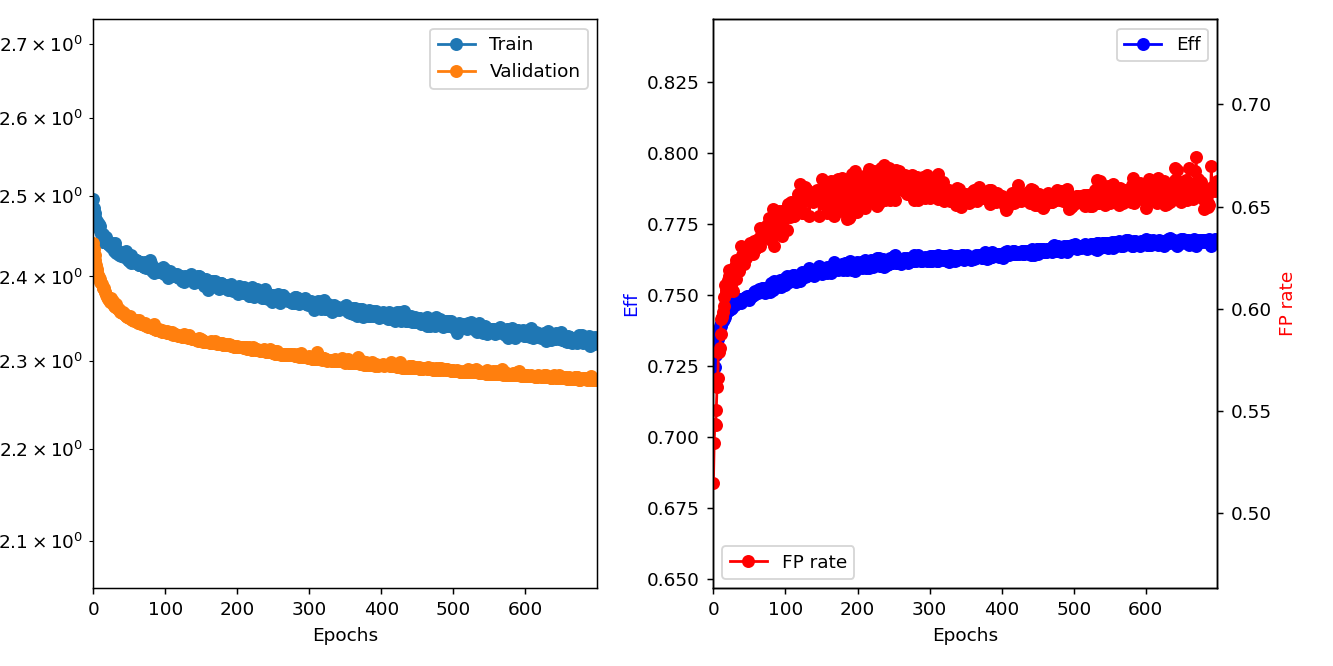

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Epoch 0: train=2.49614, val=2.44126, took 38.93 s
  Validation Found 7775 of 10819, added 1030 (eff 71.86%) (0.515 FP/event)


Epoch 1: train=2.48474, val=2.43351, took 38.476 s
  Validation Found 7806 of 10819, added 1069 (eff 72.15%) (0.534 FP/event)


Epoch 2: train=2.47836, val=2.4263, took 38.497 s
  Validation Found 7839 of 10819, added 1088 (eff 72.46%) (0.544 FP/event)


Epoch 3: train=2.47386, val=2.41983, took 38.932 s
  Validation Found 7887 of 10819, added 1087 (eff 72.90%) (0.543 FP/event)


Epoch 4: train=2.46862, val=2.4139, took 38.989 s
  Validation Found 7902 of 10819, added 1102 (eff 73.04%) (0.551 FP/event)


Epoch 5: train=2.4678, val=2.40965, took 39.166 s
  Validation Found 7929 of 10819, added 1124 (eff 73.29%) (0.562 FP/event)


Epoch 6: train=2.46575, val=2.40572, took 39.011 s
  Validation Found 7949 of 10819, added 1133 (eff 73.47%) (0.566 FP/event)


Epoch 7: train=2.46073, val=2.40172, took 39.169 s
  Validation Found 7962 of 10819, added 1158 (eff 73.59%) (0.579 FP/event)


Epoch 8: train=2.46501, val=2.39906, took 39.147 s
  Validation Found 7982 of 10819, added 1158 (eff 73.78%) (0.579 FP/event)


Epoch 9: train=2.46192, val=2.39648, took 39.087 s
  Validation Found 7995 of 10819, added 1162 (eff 73.90%) (0.581 FP/event)


Epoch 10: train=2.45598, val=2.39376, took 38.935 s
  Validation Found 7995 of 10819, added 1176 (eff 73.90%) (0.588 FP/event)


Epoch 11: train=2.45205, val=2.39159, took 38.957 s
  Validation Found 8009 of 10819, added 1191 (eff 74.03%) (0.595 FP/event)


Epoch 12: train=2.44996, val=2.39046, took 38.955 s
  Validation Found 8018 of 10819, added 1193 (eff 74.11%) (0.596 FP/event)


Epoch 13: train=2.45238, val=2.38607, took 38.936 s
  Validation Found 8016 of 10819, added 1197 (eff 74.09%) (0.598 FP/event)


Epoch 14: train=2.44221, val=2.38595, took 38.963 s
  Validation Found 8025 of 10819, added 1203 (eff 74.18%) (0.601 FP/event)


Epoch 15: train=2.44271, val=2.3855, took 39.068 s
  Validation Found 8035 of 10819, added 1212 (eff 74.27%) (0.606 FP/event)


Epoch 16: train=2.44759, val=2.38178, took 39.244 s
  Validation Found 8030 of 10819, added 1224 (eff 74.22%) (0.612 FP/event)


Epoch 17: train=2.44496, val=2.3807, took 39.183 s
  Validation Found 8056 of 10819, added 1216 (eff 74.46%) (0.608 FP/event)


Epoch 18: train=2.44856, val=2.37727, took 38.877 s
  Validation Found 8058 of 10819, added 1219 (eff 74.48%) (0.609 FP/event)


Epoch 19: train=2.44082, val=2.3758, took 39.013 s
  Validation Found 8055 of 10819, added 1225 (eff 74.45%) (0.612 FP/event)


Epoch 20: train=2.43916, val=2.37556, took 39.066 s
  Validation Found 8054 of 10819, added 1229 (eff 74.44%) (0.614 FP/event)


Epoch 21: train=2.44142, val=2.37309, took 38.96 s
  Validation Found 8057 of 10819, added 1239 (eff 74.47%) (0.619 FP/event)


Epoch 22: train=2.43897, val=2.37168, took 39.114 s
  Validation Found 8062 of 10819, added 1233 (eff 74.52%) (0.616 FP/event)


Epoch 23: train=2.43953, val=2.37119, took 38.946 s
  Validation Found 8065 of 10819, added 1234 (eff 74.54%) (0.617 FP/event)


Epoch 24: train=2.43941, val=2.3694, took 39.028 s
  Validation Found 8063 of 10819, added 1237 (eff 74.53%) (0.618 FP/event)


Epoch 25: train=2.43646, val=2.37356, took 38.875 s
  Validation Found 8079 of 10819, added 1224 (eff 74.67%) (0.612 FP/event)


Epoch 26: train=2.44085, val=2.36826, took 38.908 s
  Validation Found 8064 of 10819, added 1238 (eff 74.54%) (0.619 FP/event)


Epoch 27: train=2.43685, val=2.37036, took 39.104 s
  Validation Found 8084 of 10819, added 1218 (eff 74.72%) (0.609 FP/event)


Epoch 28: train=2.43604, val=2.36677, took 39.078 s
  Validation Found 8077 of 10819, added 1235 (eff 74.66%) (0.617 FP/event)


Epoch 29: train=2.43118, val=2.36464, took 39.134 s
  Validation Found 8083 of 10819, added 1240 (eff 74.71%) (0.62 FP/event)


Epoch 30: train=2.44068, val=2.364, took 38.943 s
  Validation Found 8076 of 10819, added 1242 (eff 74.65%) (0.621 FP/event)


Epoch 31: train=2.43499, val=2.3631, took 38.884 s
  Validation Found 8080 of 10819, added 1248 (eff 74.68%) (0.624 FP/event)


Epoch 32: train=2.4284, val=2.36686, took 38.808 s
  Validation Found 8092 of 10819, added 1230 (eff 74.79%) (0.615 FP/event)


Epoch 33: train=2.4322, val=2.36239, took 38.992 s
  Validation Found 8087 of 10819, added 1241 (eff 74.75%) (0.62 FP/event)


Epoch 34: train=2.4293, val=2.3611, took 38.891 s
  Validation Found 8088 of 10819, added 1241 (eff 74.76%) (0.62 FP/event)


Epoch 35: train=2.43049, val=2.36088, took 39.028 s
  Validation Found 8098 of 10819, added 1240 (eff 74.85%) (0.62 FP/event)


Epoch 36: train=2.42582, val=2.36052, took 39.143 s
  Validation Found 8097 of 10819, added 1238 (eff 74.84%) (0.619 FP/event)


Epoch 37: train=2.42744, val=2.35738, took 38.856 s
  Validation Found 8095 of 10819, added 1248 (eff 74.82%) (0.624 FP/event)


Epoch 38: train=2.42779, val=2.35762, took 39.046 s
  Validation Found 8085 of 10819, added 1262 (eff 74.73%) (0.631 FP/event)


Epoch 39: train=2.42501, val=2.35696, took 39.014 s
  Validation Found 8091 of 10819, added 1250 (eff 74.79%) (0.625 FP/event)


Epoch 40: train=2.42576, val=2.35634, took 39.144 s
  Validation Found 8094 of 10819, added 1253 (eff 74.81%) (0.626 FP/event)


Epoch 41: train=2.42566, val=2.35644, took 39.078 s
  Validation Found 8097 of 10819, added 1247 (eff 74.84%) (0.623 FP/event)


Epoch 42: train=2.42877, val=2.35695, took 39.006 s
  Validation Found 8105 of 10819, added 1244 (eff 74.91%) (0.622 FP/event)


Epoch 43: train=2.42387, val=2.35449, took 38.912 s
  Validation Found 8096 of 10819, added 1257 (eff 74.83%) (0.628 FP/event)


Epoch 44: train=2.42516, val=2.35439, took 39.105 s
  Validation Found 8103 of 10819, added 1250 (eff 74.90%) (0.625 FP/event)


Epoch 45: train=2.43109, val=2.35231, took 38.964 s
  Validation Found 8106 of 10819, added 1250 (eff 74.92%) (0.625 FP/event)


Epoch 46: train=2.42362, val=2.35278, took 39.079 s
  Validation Found 8111 of 10819, added 1254 (eff 74.97%) (0.627 FP/event)


Epoch 47: train=2.42523, val=2.3514, took 38.878 s
  Validation Found 8106 of 10819, added 1256 (eff 74.92%) (0.628 FP/event)


Epoch 48: train=2.42389, val=2.35123, took 39.022 s
  Validation Found 8105 of 10819, added 1259 (eff 74.91%) (0.629 FP/event)


Epoch 49: train=2.41998, val=2.351, took 38.873 s
  Validation Found 8097 of 10819, added 1262 (eff 74.84%) (0.631 FP/event)


Epoch 50: train=2.41919, val=2.34982, took 38.945 s
  Validation Found 8111 of 10819, added 1257 (eff 74.97%) (0.628 FP/event)


Epoch 51: train=2.42201, val=2.35246, took 38.832 s
  Validation Found 8112 of 10819, added 1265 (eff 74.98%) (0.632 FP/event)


Epoch 52: train=2.41693, val=2.35013, took 38.866 s
  Validation Found 8106 of 10819, added 1258 (eff 74.92%) (0.629 FP/event)


Epoch 53: train=2.42626, val=2.34883, took 38.854 s
  Validation Found 8112 of 10819, added 1260 (eff 74.98%) (0.63 FP/event)


Epoch 54: train=2.42241, val=2.34777, took 38.864 s
  Validation Found 8115 of 10819, added 1262 (eff 75.01%) (0.631 FP/event)


Epoch 55: train=2.42046, val=2.34787, took 39.032 s
  Validation Found 8117 of 10819, added 1254 (eff 75.03%) (0.627 FP/event)


Epoch 56: train=2.41974, val=2.34777, took 38.917 s
  Validation Found 8115 of 10819, added 1267 (eff 75.01%) (0.633 FP/event)


Epoch 57: train=2.42068, val=2.34704, took 38.856 s
  Validation Found 8125 of 10819, added 1258 (eff 75.10%) (0.629 FP/event)


Epoch 58: train=2.41612, val=2.34776, took 38.848 s
  Validation Found 8129 of 10819, added 1259 (eff 75.14%) (0.629 FP/event)


Epoch 59: train=2.42037, val=2.34656, took 39.069 s
  Validation Found 8125 of 10819, added 1260 (eff 75.10%) (0.63 FP/event)


Epoch 60: train=2.42002, val=2.34732, took 38.864 s
  Validation Found 8125 of 10819, added 1264 (eff 75.10%) (0.632 FP/event)


Epoch 61: train=2.41933, val=2.34542, took 39.042 s
  Validation Found 8126 of 10819, added 1262 (eff 75.11%) (0.631 FP/event)


Epoch 62: train=2.41916, val=2.34462, took 38.95 s
  Validation Found 8124 of 10819, added 1269 (eff 75.09%) (0.634 FP/event)


Epoch 63: train=2.41444, val=2.34766, took 38.945 s
  Validation Found 8138 of 10819, added 1262 (eff 75.22%) (0.631 FP/event)


Epoch 64: train=2.41381, val=2.34449, took 39.034 s
  Validation Found 8133 of 10819, added 1262 (eff 75.17%) (0.631 FP/event)


Epoch 65: train=2.41735, val=2.34409, took 38.842 s
  Validation Found 8126 of 10819, added 1280 (eff 75.11%) (0.64 FP/event)


Epoch 66: train=2.41715, val=2.34358, took 38.918 s
  Validation Found 8133 of 10819, added 1273 (eff 75.17%) (0.636 FP/event)


Epoch 67: train=2.4136, val=2.34435, took 39.006 s
  Validation Found 8141 of 10819, added 1271 (eff 75.25%) (0.635 FP/event)


Epoch 68: train=2.41467, val=2.34243, took 38.82 s
  Validation Found 8137 of 10819, added 1275 (eff 75.21%) (0.637 FP/event)


Epoch 69: train=2.41269, val=2.34275, took 38.923 s
  Validation Found 8133 of 10819, added 1275 (eff 75.17%) (0.637 FP/event)


Epoch 70: train=2.41134, val=2.34251, took 38.949 s
  Validation Found 8143 of 10819, added 1270 (eff 75.27%) (0.635 FP/event)


Epoch 71: train=2.41163, val=2.34158, took 38.821 s
  Validation Found 8124 of 10819, added 1277 (eff 75.09%) (0.638 FP/event)


Epoch 72: train=2.41748, val=2.34417, took 38.985 s
  Validation Found 8138 of 10819, added 1277 (eff 75.22%) (0.638 FP/event)


Epoch 73: train=2.41113, val=2.34137, took 38.88 s
  Validation Found 8139 of 10819, added 1275 (eff 75.23%) (0.637 FP/event)


Epoch 74: train=2.41089, val=2.34006, took 38.935 s
  Validation Found 8133 of 10819, added 1283 (eff 75.17%) (0.641 FP/event)


Epoch 75: train=2.4136, val=2.34017, took 39.045 s
  Validation Found 8137 of 10819, added 1282 (eff 75.21%) (0.641 FP/event)


Epoch 76: train=2.41298, val=2.33994, took 39.058 s
  Validation Found 8137 of 10819, added 1281 (eff 75.21%) (0.64 FP/event)


Epoch 77: train=2.41162, val=2.33978, took 38.832 s
  Validation Found 8140 of 10819, added 1289 (eff 75.24%) (0.644 FP/event)


Epoch 78: train=2.41135, val=2.34095, took 38.898 s
  Validation Found 8128 of 10819, added 1288 (eff 75.13%) (0.644 FP/event)


Epoch 79: train=2.42022, val=2.33916, took 39.03 s
  Validation Found 8133 of 10819, added 1280 (eff 75.17%) (0.64 FP/event)


Epoch 80: train=2.41611, val=2.34073, took 38.966 s
  Validation Found 8162 of 10819, added 1268 (eff 75.44%) (0.634 FP/event)


Epoch 81: train=2.40859, val=2.33835, took 38.953 s
  Validation Found 8148 of 10819, added 1276 (eff 75.31%) (0.638 FP/event)


Epoch 82: train=2.40661, val=2.33889, took 38.934 s
  Validation Found 8140 of 10819, added 1285 (eff 75.24%) (0.642 FP/event)


Epoch 83: train=2.407, val=2.33942, took 39.029 s
  Validation Found 8135 of 10819, added 1298 (eff 75.19%) (0.649 FP/event)


Epoch 84: train=2.40762, val=2.34293, took 38.971 s
  Validation Found 8169 of 10819, added 1262 (eff 75.51%) (0.631 FP/event)


Epoch 85: train=2.40384, val=2.33697, took 39.079 s
  Validation Found 8146 of 10819, added 1282 (eff 75.29%) (0.641 FP/event)


Epoch 86: train=2.41002, val=2.33701, took 38.875 s
  Validation Found 8151 of 10819, added 1287 (eff 75.34%) (0.643 FP/event)


Epoch 87: train=2.40872, val=2.33632, took 38.885 s
  Validation Found 8145 of 10819, added 1290 (eff 75.28%) (0.645 FP/event)


Epoch 88: train=2.40876, val=2.33589, took 39.013 s
  Validation Found 8144 of 10819, added 1290 (eff 75.27%) (0.645 FP/event)


Epoch 89: train=2.40907, val=2.33623, took 38.929 s
  Validation Found 8157 of 10819, added 1284 (eff 75.40%) (0.642 FP/event)


Epoch 90: train=2.40566, val=2.33552, took 38.979 s
  Validation Found 8162 of 10819, added 1283 (eff 75.44%) (0.641 FP/event)


Epoch 91: train=2.40569, val=2.33532, took 38.856 s
  Validation Found 8150 of 10819, added 1296 (eff 75.33%) (0.648 FP/event)


Epoch 92: train=2.40659, val=2.33695, took 39.012 s
  Validation Found 8171 of 10819, added 1281 (eff 75.52%) (0.64 FP/event)


Epoch 93: train=2.40515, val=2.33481, took 38.954 s
  Validation Found 8164 of 10819, added 1289 (eff 75.46%) (0.644 FP/event)


Epoch 94: train=2.40871, val=2.3344, took 38.856 s
  Validation Found 8144 of 10819, added 1291 (eff 75.27%) (0.645 FP/event)


Epoch 95: train=2.40717, val=2.33609, took 38.958 s
  Validation Found 8173 of 10819, added 1272 (eff 75.54%) (0.636 FP/event)


Epoch 96: train=2.40766, val=2.33397, took 38.983 s
  Validation Found 8169 of 10819, added 1287 (eff 75.51%) (0.643 FP/event)


Epoch 97: train=2.41169, val=2.33348, took 38.875 s
  Validation Found 8152 of 10819, added 1296 (eff 75.35%) (0.648 FP/event)


Epoch 98: train=2.40858, val=2.33352, took 38.923 s
  Validation Found 8153 of 10819, added 1295 (eff 75.36%) (0.647 FP/event)


Epoch 99: train=2.40268, val=2.33349, took 38.92 s
  Validation Found 8154 of 10819, added 1297 (eff 75.37%) (0.648 FP/event)


Epoch 100: train=2.40863, val=2.33339, took 38.988 s
  Validation Found 8181 of 10819, added 1289 (eff 75.62%) (0.644 FP/event)


Epoch 101: train=2.40494, val=2.33297, took 38.918 s
  Validation Found 8162 of 10819, added 1298 (eff 75.44%) (0.649 FP/event)


Epoch 102: train=2.40166, val=2.33441, took 39.003 s
  Validation Found 8188 of 10819, added 1278 (eff 75.68%) (0.639 FP/event)


Epoch 103: train=2.40355, val=2.33287, took 39.089 s
  Validation Found 8165 of 10819, added 1303 (eff 75.47%) (0.651 FP/event)


Epoch 104: train=2.39811, val=2.33257, took 38.898 s
  Validation Found 8164 of 10819, added 1301 (eff 75.46%) (0.65 FP/event)


Epoch 105: train=2.40492, val=2.3327, took 38.869 s
  Validation Found 8165 of 10819, added 1301 (eff 75.47%) (0.65 FP/event)


Epoch 106: train=2.4068, val=2.33255, took 39.0 s
  Validation Found 8180 of 10819, added 1290 (eff 75.61%) (0.645 FP/event)


Epoch 107: train=2.40067, val=2.33312, took 38.996 s
  Validation Found 8185 of 10819, added 1293 (eff 75.65%) (0.646 FP/event)


Epoch 108: train=2.40262, val=2.33126, took 39.072 s
  Validation Found 8173 of 10819, added 1305 (eff 75.54%) (0.652 FP/event)


Epoch 109: train=2.40331, val=2.33365, took 38.9 s
  Validation Found 8186 of 10819, added 1291 (eff 75.66%) (0.645 FP/event)


Epoch 110: train=2.401, val=2.33242, took 38.95 s
  Validation Found 8192 of 10819, added 1291 (eff 75.72%) (0.645 FP/event)


Epoch 111: train=2.4022, val=2.33059, took 38.932 s
  Validation Found 8185 of 10819, added 1301 (eff 75.65%) (0.65 FP/event)


Epoch 112: train=2.40234, val=2.33104, took 38.893 s
  Validation Found 8192 of 10819, added 1291 (eff 75.72%) (0.645 FP/event)


Epoch 113: train=2.40153, val=2.33147, took 38.885 s
  Validation Found 8186 of 10819, added 1295 (eff 75.66%) (0.647 FP/event)


Epoch 114: train=2.40274, val=2.33065, took 39.06 s
  Validation Found 8165 of 10819, added 1303 (eff 75.47%) (0.651 FP/event)


Epoch 115: train=2.40018, val=2.33025, took 39.042 s
  Validation Found 8184 of 10819, added 1305 (eff 75.64%) (0.652 FP/event)


Epoch 116: train=2.39994, val=2.32966, took 39.024 s
  Validation Found 8172 of 10819, added 1304 (eff 75.53%) (0.652 FP/event)


Epoch 117: train=2.4025, val=2.33004, took 38.901 s
  Validation Found 8177 of 10819, added 1313 (eff 75.58%) (0.656 FP/event)


Epoch 118: train=2.39978, val=2.32913, took 38.867 s
  Validation Found 8170 of 10819, added 1307 (eff 75.52%) (0.653 FP/event)


Epoch 119: train=2.39797, val=2.32909, took 38.927 s
  Validation Found 8176 of 10819, added 1310 (eff 75.57%) (0.655 FP/event)


Epoch 120: train=2.39798, val=2.32942, took 39.055 s
  Validation Found 8167 of 10819, added 1323 (eff 75.49%) (0.661 FP/event)


Epoch 121: train=2.40084, val=2.32929, took 38.928 s
  Validation Found 8174 of 10819, added 1314 (eff 75.55%) (0.657 FP/event)


Epoch 122: train=2.4005, val=2.32873, took 39.025 s
  Validation Found 8190 of 10819, added 1307 (eff 75.70%) (0.653 FP/event)


Epoch 123: train=2.39707, val=2.33057, took 38.984 s
  Validation Found 8204 of 10819, added 1294 (eff 75.83%) (0.647 FP/event)


Epoch 124: train=2.39444, val=2.32714, took 39.004 s
  Validation Found 8184 of 10819, added 1316 (eff 75.64%) (0.658 FP/event)


Epoch 125: train=2.39899, val=2.32708, took 38.829 s
  Validation Found 8193 of 10819, added 1310 (eff 75.73%) (0.655 FP/event)


Epoch 126: train=2.39367, val=2.33063, took 38.923 s
  Validation Found 8200 of 10819, added 1294 (eff 75.79%) (0.647 FP/event)


Epoch 127: train=2.39738, val=2.32884, took 38.875 s
  Validation Found 8185 of 10819, added 1320 (eff 75.65%) (0.66 FP/event)


Epoch 128: train=2.40025, val=2.32773, took 38.864 s
  Validation Found 8192 of 10819, added 1306 (eff 75.72%) (0.653 FP/event)


Epoch 129: train=2.39778, val=2.32717, took 38.89 s
  Validation Found 8189 of 10819, added 1318 (eff 75.69%) (0.659 FP/event)


Epoch 130: train=2.39858, val=2.32787, took 38.952 s
  Validation Found 8187 of 10819, added 1317 (eff 75.67%) (0.658 FP/event)


Epoch 131: train=2.3974, val=2.32742, took 38.852 s
  Validation Found 8198 of 10819, added 1315 (eff 75.77%) (0.657 FP/event)


Epoch 132: train=2.39943, val=2.32636, took 38.952 s
  Validation Found 8197 of 10819, added 1315 (eff 75.76%) (0.657 FP/event)


Epoch 133: train=2.39864, val=2.32957, took 38.812 s
  Validation Found 8218 of 10819, added 1291 (eff 75.96%) (0.645 FP/event)


Epoch 134: train=2.39604, val=2.32606, took 38.913 s
  Validation Found 8201 of 10819, added 1310 (eff 75.80%) (0.655 FP/event)


Epoch 135: train=2.39939, val=2.32632, took 38.958 s
  Validation Found 8199 of 10819, added 1306 (eff 75.78%) (0.653 FP/event)


Epoch 136: train=2.40316, val=2.32597, took 38.89 s
  Validation Found 8201 of 10819, added 1311 (eff 75.80%) (0.655 FP/event)


Epoch 137: train=2.39587, val=2.32587, took 38.818 s
  Validation Found 8200 of 10819, added 1308 (eff 75.79%) (0.654 FP/event)


Epoch 138: train=2.39539, val=2.32565, took 38.83 s
  Validation Found 8195 of 10819, added 1305 (eff 75.75%) (0.652 FP/event)


Epoch 139: train=2.39564, val=2.32545, took 38.831 s
  Validation Found 8188 of 10819, added 1313 (eff 75.68%) (0.656 FP/event)


Epoch 140: train=2.39241, val=2.32534, took 38.909 s
  Validation Found 8199 of 10819, added 1312 (eff 75.78%) (0.656 FP/event)


Epoch 141: train=2.39551, val=2.32561, took 38.98 s
  Validation Found 8197 of 10819, added 1313 (eff 75.76%) (0.656 FP/event)


Epoch 142: train=2.39647, val=2.32509, took 38.923 s
  Validation Found 8194 of 10819, added 1313 (eff 75.74%) (0.656 FP/event)


Epoch 143: train=2.39386, val=2.3245, took 38.851 s
  Validation Found 8200 of 10819, added 1315 (eff 75.79%) (0.657 FP/event)


Epoch 144: train=2.39399, val=2.32457, took 38.946 s
  Validation Found 8197 of 10819, added 1317 (eff 75.76%) (0.658 FP/event)


Epoch 145: train=2.40083, val=2.32405, took 38.878 s
  Validation Found 8203 of 10819, added 1313 (eff 75.82%) (0.656 FP/event)


Epoch 146: train=2.39732, val=2.32345, took 38.898 s
  Validation Found 8204 of 10819, added 1313 (eff 75.83%) (0.656 FP/event)


Epoch 147: train=2.4002, val=2.32596, took 38.915 s
  Validation Found 8226 of 10819, added 1291 (eff 76.03%) (0.645 FP/event)


Epoch 148: train=2.39925, val=2.32349, took 38.944 s
  Validation Found 8209 of 10819, added 1309 (eff 75.88%) (0.654 FP/event)


Epoch 149: train=2.39374, val=2.32281, took 38.894 s
  Validation Found 8204 of 10819, added 1313 (eff 75.83%) (0.656 FP/event)


Epoch 150: train=2.39426, val=2.32528, took 39.081 s
  Validation Found 8195 of 10819, added 1328 (eff 75.75%) (0.664 FP/event)


Epoch 151: train=2.3926, val=2.32364, took 38.996 s
  Validation Found 8209 of 10819, added 1316 (eff 75.88%) (0.658 FP/event)


Epoch 152: train=2.39341, val=2.32249, took 38.917 s
  Validation Found 8215 of 10819, added 1303 (eff 75.93%) (0.651 FP/event)


Epoch 153: train=2.39345, val=2.32197, took 38.976 s
  Validation Found 8212 of 10819, added 1309 (eff 75.90%) (0.654 FP/event)


Epoch 154: train=2.38876, val=2.3227, took 38.892 s
  Validation Found 8210 of 10819, added 1309 (eff 75.89%) (0.654 FP/event)


Epoch 155: train=2.39258, val=2.32165, took 38.825 s
  Validation Found 8205 of 10819, added 1313 (eff 75.84%) (0.656 FP/event)


Epoch 156: train=2.39721, val=2.32126, took 38.93 s
  Validation Found 8202 of 10819, added 1320 (eff 75.81%) (0.66 FP/event)


Epoch 157: train=2.3925, val=2.32188, took 38.933 s
  Validation Found 8198 of 10819, added 1323 (eff 75.77%) (0.661 FP/event)


Epoch 158: train=2.38987, val=2.32171, took 39.077 s
  Validation Found 8220 of 10819, added 1294 (eff 75.98%) (0.647 FP/event)


Epoch 159: train=2.38312, val=2.32194, took 38.97 s
  Validation Found 8204 of 10819, added 1316 (eff 75.83%) (0.658 FP/event)


Epoch 160: train=2.38849, val=2.32203, took 38.841 s
  Validation Found 8211 of 10819, added 1307 (eff 75.89%) (0.653 FP/event)


Epoch 161: train=2.39325, val=2.32132, took 39.206 s
  Validation Found 8217 of 10819, added 1302 (eff 75.95%) (0.651 FP/event)


Epoch 162: train=2.39401, val=2.32084, took 38.954 s
  Validation Found 8211 of 10819, added 1310 (eff 75.89%) (0.655 FP/event)


Epoch 163: train=2.39271, val=2.32248, took 38.882 s
  Validation Found 8198 of 10819, added 1326 (eff 75.77%) (0.663 FP/event)


Epoch 164: train=2.38811, val=2.32062, took 38.923 s
  Validation Found 8211 of 10819, added 1323 (eff 75.89%) (0.661 FP/event)


Epoch 165: train=2.38805, val=2.32021, took 38.918 s
  Validation Found 8221 of 10819, added 1307 (eff 75.99%) (0.653 FP/event)


Epoch 166: train=2.39419, val=2.3217, took 38.984 s
  Validation Found 8230 of 10819, added 1298 (eff 76.07%) (0.649 FP/event)


Epoch 167: train=2.39295, val=2.32194, took 38.945 s
  Validation Found 8239 of 10819, added 1291 (eff 76.15%) (0.645 FP/event)


Epoch 168: train=2.39197, val=2.32034, took 39.005 s
  Validation Found 8227 of 10819, added 1305 (eff 76.04%) (0.652 FP/event)


Epoch 169: train=2.39402, val=2.32252, took 38.923 s
  Validation Found 8232 of 10819, added 1295 (eff 76.09%) (0.647 FP/event)


Epoch 170: train=2.39045, val=2.32021, took 38.914 s
  Validation Found 8226 of 10819, added 1300 (eff 76.03%) (0.65 FP/event)


Epoch 171: train=2.39006, val=2.3203, took 38.965 s
  Validation Found 8215 of 10819, added 1327 (eff 75.93%) (0.663 FP/event)


Epoch 172: train=2.38894, val=2.3189, took 38.968 s
  Validation Found 8220 of 10819, added 1309 (eff 75.98%) (0.654 FP/event)


Epoch 173: train=2.38618, val=2.32048, took 38.894 s
  Validation Found 8212 of 10819, added 1328 (eff 75.90%) (0.664 FP/event)


Epoch 174: train=2.38543, val=2.31893, took 38.844 s
  Validation Found 8217 of 10819, added 1319 (eff 75.95%) (0.659 FP/event)


Epoch 175: train=2.38752, val=2.3196, took 38.943 s
  Validation Found 8231 of 10819, added 1307 (eff 76.08%) (0.653 FP/event)


Epoch 176: train=2.39097, val=2.31907, took 38.897 s
  Validation Found 8218 of 10819, added 1315 (eff 75.96%) (0.657 FP/event)


Epoch 177: train=2.3919, val=2.31893, took 38.844 s
  Validation Found 8228 of 10819, added 1314 (eff 76.05%) (0.657 FP/event)


Epoch 178: train=2.39225, val=2.32021, took 38.961 s
  Validation Found 8234 of 10819, added 1296 (eff 76.11%) (0.648 FP/event)


Epoch 179: train=2.39121, val=2.3204, took 38.909 s
  Validation Found 8213 of 10819, added 1329 (eff 75.91%) (0.664 FP/event)


Epoch 180: train=2.38744, val=2.3185, took 38.835 s
  Validation Found 8212 of 10819, added 1323 (eff 75.90%) (0.661 FP/event)


Epoch 181: train=2.38935, val=2.31884, took 39.08 s
  Validation Found 8214 of 10819, added 1321 (eff 75.92%) (0.66 FP/event)


Epoch 182: train=2.38771, val=2.31854, took 39.006 s
  Validation Found 8213 of 10819, added 1320 (eff 75.91%) (0.66 FP/event)


Epoch 183: train=2.38784, val=2.31958, took 39.048 s
  Validation Found 8235 of 10819, added 1300 (eff 76.12%) (0.65 FP/event)


Epoch 184: train=2.38911, val=2.31862, took 38.863 s
  Validation Found 8234 of 10819, added 1301 (eff 76.11%) (0.65 FP/event)


Epoch 185: train=2.38742, val=2.31905, took 38.981 s
  Validation Found 8236 of 10819, added 1288 (eff 76.13%) (0.644 FP/event)


Epoch 186: train=2.38479, val=2.31827, took 38.875 s
  Validation Found 8211 of 10819, added 1326 (eff 75.89%) (0.663 FP/event)


Epoch 187: train=2.38398, val=2.31789, took 39.092 s
  Validation Found 8236 of 10819, added 1296 (eff 76.13%) (0.648 FP/event)


Epoch 188: train=2.38745, val=2.31885, took 38.929 s
  Validation Found 8241 of 10819, added 1289 (eff 76.17%) (0.644 FP/event)


Epoch 189: train=2.38498, val=2.31884, took 38.928 s
  Validation Found 8245 of 10819, added 1291 (eff 76.21%) (0.645 FP/event)


Epoch 190: train=2.38427, val=2.31831, took 39.094 s
  Validation Found 8234 of 10819, added 1300 (eff 76.11%) (0.65 FP/event)


Epoch 191: train=2.38906, val=2.31697, took 38.94 s
  Validation Found 8227 of 10819, added 1307 (eff 76.04%) (0.653 FP/event)


Epoch 192: train=2.39033, val=2.31847, took 38.945 s
  Validation Found 8212 of 10819, added 1333 (eff 75.90%) (0.666 FP/event)


Epoch 193: train=2.38509, val=2.31668, took 39.082 s
  Validation Found 8217 of 10819, added 1329 (eff 75.95%) (0.664 FP/event)


Epoch 194: train=2.38276, val=2.31662, took 38.87 s
  Validation Found 8218 of 10819, added 1327 (eff 75.96%) (0.663 FP/event)


Epoch 195: train=2.3869, val=2.31594, took 39.041 s
  Validation Found 8230 of 10819, added 1314 (eff 76.07%) (0.657 FP/event)


Epoch 196: train=2.38632, val=2.31708, took 38.877 s
  Validation Found 8208 of 10819, added 1335 (eff 75.87%) (0.667 FP/event)


Epoch 197: train=2.38777, val=2.31592, took 39.067 s
  Validation Found 8224 of 10819, added 1319 (eff 76.01%) (0.659 FP/event)


Epoch 198: train=2.3858, val=2.31606, took 38.82 s
  Validation Found 8220 of 10819, added 1324 (eff 75.98%) (0.662 FP/event)


Epoch 199: train=2.38534, val=2.31667, took 39.027 s
  Validation Found 8242 of 10819, added 1295 (eff 76.18%) (0.647 FP/event)


Epoch 200: train=2.38743, val=2.31621, took 38.969 s
  Validation Found 8225 of 10819, added 1328 (eff 76.02%) (0.664 FP/event)


Epoch 201: train=2.37839, val=2.31586, took 38.933 s
  Validation Found 8223 of 10819, added 1326 (eff 76.01%) (0.663 FP/event)


Epoch 202: train=2.3823, val=2.31602, took 38.871 s
  Validation Found 8233 of 10819, added 1313 (eff 76.10%) (0.656 FP/event)


Epoch 203: train=2.38847, val=2.31568, took 39.011 s
  Validation Found 8230 of 10819, added 1322 (eff 76.07%) (0.661 FP/event)


Epoch 204: train=2.38194, val=2.3157, took 38.883 s
  Validation Found 8228 of 10819, added 1321 (eff 76.05%) (0.66 FP/event)


Epoch 205: train=2.3841, val=2.31614, took 39.024 s
  Validation Found 8241 of 10819, added 1304 (eff 76.17%) (0.652 FP/event)


Epoch 206: train=2.38465, val=2.3157, took 38.816 s
  Validation Found 8219 of 10819, added 1324 (eff 75.97%) (0.662 FP/event)


Epoch 207: train=2.38196, val=2.31537, took 39.008 s
  Validation Found 8230 of 10819, added 1315 (eff 76.07%) (0.657 FP/event)


Epoch 208: train=2.38048, val=2.31569, took 39.063 s
  Validation Found 8237 of 10819, added 1303 (eff 76.13%) (0.651 FP/event)


Epoch 209: train=2.38668, val=2.31479, took 39.031 s
  Validation Found 8230 of 10819, added 1319 (eff 76.07%) (0.659 FP/event)


Epoch 210: train=2.38311, val=2.31499, took 38.95 s
  Validation Found 8227 of 10819, added 1320 (eff 76.04%) (0.66 FP/event)


Epoch 211: train=2.37977, val=2.31618, took 38.916 s
  Validation Found 8250 of 10819, added 1299 (eff 76.25%) (0.649 FP/event)


Epoch 212: train=2.38234, val=2.31541, took 38.899 s
  Validation Found 8216 of 10819, added 1332 (eff 75.94%) (0.666 FP/event)


Epoch 213: train=2.38103, val=2.31448, took 39.028 s
  Validation Found 8221 of 10819, added 1332 (eff 75.99%) (0.666 FP/event)


Epoch 214: train=2.38328, val=2.31318, took 39.067 s
  Validation Found 8238 of 10819, added 1320 (eff 76.14%) (0.66 FP/event)


Epoch 215: train=2.37887, val=2.31353, took 38.958 s
  Validation Found 8246 of 10819, added 1310 (eff 76.22%) (0.655 FP/event)


Epoch 216: train=2.37622, val=2.31549, took 38.919 s
  Validation Found 8219 of 10819, added 1337 (eff 75.97%) (0.668 FP/event)


Epoch 217: train=2.38285, val=2.31349, took 38.909 s
  Validation Found 8238 of 10819, added 1318 (eff 76.14%) (0.659 FP/event)


Epoch 218: train=2.37649, val=2.31377, took 38.86 s
  Validation Found 8247 of 10819, added 1306 (eff 76.23%) (0.653 FP/event)


Epoch 219: train=2.38177, val=2.31301, took 39.045 s
  Validation Found 8234 of 10819, added 1314 (eff 76.11%) (0.657 FP/event)


Epoch 220: train=2.38671, val=2.31246, took 38.976 s
  Validation Found 8232 of 10819, added 1326 (eff 76.09%) (0.663 FP/event)


Epoch 221: train=2.37614, val=2.31264, took 38.839 s
  Validation Found 8237 of 10819, added 1323 (eff 76.13%) (0.661 FP/event)


Epoch 222: train=2.37959, val=2.31536, took 39.04 s
  Validation Found 8221 of 10819, added 1327 (eff 75.99%) (0.663 FP/event)


Epoch 223: train=2.37555, val=2.3148, took 38.962 s
  Validation Found 8230 of 10819, added 1335 (eff 76.07%) (0.667 FP/event)


Epoch 224: train=2.38114, val=2.31333, took 39.001 s
  Validation Found 8243 of 10819, added 1314 (eff 76.19%) (0.657 FP/event)


Epoch 225: train=2.38072, val=2.31311, took 38.954 s
  Validation Found 8236 of 10819, added 1327 (eff 76.13%) (0.663 FP/event)


Epoch 226: train=2.38262, val=2.31244, took 38.906 s
  Validation Found 8240 of 10819, added 1313 (eff 76.16%) (0.656 FP/event)


Epoch 227: train=2.38475, val=2.31388, took 38.944 s
  Validation Found 8257 of 10819, added 1301 (eff 76.32%) (0.65 FP/event)


Epoch 228: train=2.37934, val=2.31226, took 39.044 s
  Validation Found 8241 of 10819, added 1318 (eff 76.17%) (0.659 FP/event)


Epoch 229: train=2.38285, val=2.31242, took 38.974 s
  Validation Found 8231 of 10819, added 1330 (eff 76.08%) (0.665 FP/event)


Epoch 230: train=2.3769, val=2.31292, took 38.899 s
  Validation Found 8254 of 10819, added 1304 (eff 76.29%) (0.652 FP/event)


Epoch 231: train=2.37764, val=2.31254, took 38.962 s
  Validation Found 8226 of 10819, added 1333 (eff 76.03%) (0.666 FP/event)


Epoch 232: train=2.37812, val=2.31165, took 38.943 s
  Validation Found 8230 of 10819, added 1330 (eff 76.07%) (0.665 FP/event)


Epoch 233: train=2.37763, val=2.31142, took 39.086 s
  Validation Found 8224 of 10819, added 1338 (eff 76.01%) (0.669 FP/event)


Epoch 234: train=2.37405, val=2.31157, took 39.075 s
  Validation Found 8231 of 10819, added 1334 (eff 76.08%) (0.667 FP/event)


Epoch 235: train=2.38015, val=2.31091, took 38.864 s
  Validation Found 8235 of 10819, added 1329 (eff 76.12%) (0.664 FP/event)


Epoch 236: train=2.3753, val=2.31125, took 38.967 s
  Validation Found 8251 of 10819, added 1314 (eff 76.26%) (0.657 FP/event)


Epoch 237: train=2.37442, val=2.31405, took 38.941 s
  Validation Found 8221 of 10819, added 1341 (eff 75.99%) (0.67 FP/event)


Epoch 238: train=2.37506, val=2.31197, took 38.88 s
  Validation Found 8249 of 10819, added 1307 (eff 76.25%) (0.653 FP/event)


Epoch 239: train=2.38469, val=2.31101, took 38.879 s
  Validation Found 8229 of 10819, added 1335 (eff 76.06%) (0.667 FP/event)


Epoch 240: train=2.38051, val=2.31055, took 38.909 s
  Validation Found 8236 of 10819, added 1327 (eff 76.13%) (0.663 FP/event)


Epoch 241: train=2.37954, val=2.31003, took 39.054 s
  Validation Found 8230 of 10819, added 1330 (eff 76.07%) (0.665 FP/event)


Epoch 242: train=2.37884, val=2.30992, took 38.848 s
  Validation Found 8242 of 10819, added 1323 (eff 76.18%) (0.661 FP/event)


Epoch 243: train=2.37243, val=2.30993, took 39.024 s
  Validation Found 8232 of 10819, added 1338 (eff 76.09%) (0.669 FP/event)


Epoch 244: train=2.37518, val=2.30952, took 38.909 s
  Validation Found 8238 of 10819, added 1331 (eff 76.14%) (0.665 FP/event)


Epoch 245: train=2.37564, val=2.31187, took 38.9 s
  Validation Found 8255 of 10819, added 1307 (eff 76.30%) (0.653 FP/event)


Epoch 246: train=2.37276, val=2.31352, took 38.9 s
  Validation Found 8238 of 10819, added 1335 (eff 76.14%) (0.667 FP/event)


Epoch 247: train=2.37593, val=2.3107, took 39.12 s
  Validation Found 8238 of 10819, added 1333 (eff 76.14%) (0.666 FP/event)


Epoch 248: train=2.36975, val=2.311, took 39.047 s
  Validation Found 8236 of 10819, added 1333 (eff 76.13%) (0.666 FP/event)


Epoch 249: train=2.37821, val=2.30913, took 39.027 s
  Validation Found 8243 of 10819, added 1325 (eff 76.19%) (0.662 FP/event)


Epoch 250: train=2.37578, val=2.30904, took 38.906 s
  Validation Found 8248 of 10819, added 1322 (eff 76.24%) (0.661 FP/event)


Epoch 251: train=2.37401, val=2.31035, took 39.075 s
  Validation Found 8263 of 10819, added 1315 (eff 76.37%) (0.657 FP/event)


Epoch 252: train=2.37336, val=2.31066, took 39.1 s
  Validation Found 8269 of 10819, added 1307 (eff 76.43%) (0.653 FP/event)


Epoch 253: train=2.3754, val=2.30799, took 39.061 s
  Validation Found 8243 of 10819, added 1333 (eff 76.19%) (0.666 FP/event)


Epoch 254: train=2.37347, val=2.30815, took 38.941 s
  Validation Found 8235 of 10819, added 1336 (eff 76.12%) (0.668 FP/event)


Epoch 255: train=2.37571, val=2.31068, took 38.936 s
  Validation Found 8253 of 10819, added 1325 (eff 76.28%) (0.662 FP/event)


Epoch 256: train=2.37477, val=2.3079, took 38.888 s
  Validation Found 8238 of 10819, added 1330 (eff 76.14%) (0.665 FP/event)


Epoch 257: train=2.37914, val=2.3074, took 38.924 s
  Validation Found 8237 of 10819, added 1335 (eff 76.13%) (0.667 FP/event)


Epoch 258: train=2.37683, val=2.30781, took 38.865 s
  Validation Found 8242 of 10819, added 1330 (eff 76.18%) (0.665 FP/event)


Epoch 259: train=2.36843, val=2.30786, took 38.83 s
  Validation Found 8237 of 10819, added 1324 (eff 76.13%) (0.662 FP/event)


Epoch 260: train=2.37411, val=2.30752, took 39.022 s
  Validation Found 8233 of 10819, added 1330 (eff 76.10%) (0.665 FP/event)


Epoch 261: train=2.37223, val=2.30689, took 38.93 s
  Validation Found 8237 of 10819, added 1330 (eff 76.13%) (0.665 FP/event)


Epoch 262: train=2.37771, val=2.30728, took 38.946 s
  Validation Found 8250 of 10819, added 1326 (eff 76.25%) (0.663 FP/event)


Epoch 263: train=2.37494, val=2.30676, took 38.891 s
  Validation Found 8250 of 10819, added 1326 (eff 76.25%) (0.663 FP/event)


Epoch 264: train=2.37724, val=2.30712, took 38.97 s
  Validation Found 8256 of 10819, added 1316 (eff 76.31%) (0.658 FP/event)


Epoch 265: train=2.3757, val=2.30758, took 38.935 s
  Validation Found 8245 of 10819, added 1330 (eff 76.21%) (0.665 FP/event)


Epoch 266: train=2.37196, val=2.30694, took 39.143 s
  Validation Found 8243 of 10819, added 1332 (eff 76.19%) (0.666 FP/event)


Epoch 267: train=2.37407, val=2.30795, took 39.0 s
  Validation Found 8244 of 10819, added 1323 (eff 76.20%) (0.661 FP/event)


Epoch 268: train=2.37117, val=2.30689, took 38.967 s
  Validation Found 8242 of 10819, added 1325 (eff 76.18%) (0.662 FP/event)


Epoch 269: train=2.37259, val=2.30714, took 38.991 s
  Validation Found 8254 of 10819, added 1313 (eff 76.29%) (0.656 FP/event)


Epoch 270: train=2.37003, val=2.3066, took 38.974 s
  Validation Found 8235 of 10819, added 1331 (eff 76.12%) (0.665 FP/event)


Epoch 271: train=2.37209, val=2.30743, took 38.988 s
  Validation Found 8241 of 10819, added 1325 (eff 76.17%) (0.662 FP/event)


Epoch 272: train=2.37082, val=2.30721, took 38.838 s
  Validation Found 8248 of 10819, added 1323 (eff 76.24%) (0.661 FP/event)


Epoch 273: train=2.3718, val=2.30832, took 38.835 s
  Validation Found 8243 of 10819, added 1326 (eff 76.19%) (0.663 FP/event)


Epoch 274: train=2.37174, val=2.30638, took 39.02 s
  Validation Found 8247 of 10819, added 1327 (eff 76.23%) (0.663 FP/event)


Epoch 275: train=2.36951, val=2.30786, took 39.048 s
  Validation Found 8243 of 10819, added 1327 (eff 76.19%) (0.663 FP/event)


Epoch 276: train=2.36846, val=2.30654, took 38.959 s
  Validation Found 8245 of 10819, added 1332 (eff 76.21%) (0.666 FP/event)


Epoch 277: train=2.37016, val=2.3062, took 38.861 s
  Validation Found 8244 of 10819, added 1331 (eff 76.20%) (0.665 FP/event)


Epoch 278: train=2.37123, val=2.30614, took 39.036 s
  Validation Found 8258 of 10819, added 1318 (eff 76.33%) (0.659 FP/event)


Epoch 279: train=2.3678, val=2.30806, took 39.022 s
  Validation Found 8268 of 10819, added 1307 (eff 76.42%) (0.653 FP/event)


Epoch 280: train=2.3758, val=2.30541, took 39.124 s
  Validation Found 8247 of 10819, added 1327 (eff 76.23%) (0.663 FP/event)


Epoch 281: train=2.37494, val=2.30538, took 38.866 s
  Validation Found 8245 of 10819, added 1320 (eff 76.21%) (0.66 FP/event)


Epoch 282: train=2.37075, val=2.3054, took 38.874 s
  Validation Found 8252 of 10819, added 1330 (eff 76.27%) (0.665 FP/event)


Epoch 283: train=2.36817, val=2.30532, took 39.008 s
  Validation Found 8252 of 10819, added 1322 (eff 76.27%) (0.661 FP/event)


Epoch 284: train=2.37457, val=2.30755, took 38.904 s
  Validation Found 8266 of 10819, added 1307 (eff 76.40%) (0.653 FP/event)


Epoch 285: train=2.3722, val=2.30519, took 39.013 s
  Validation Found 8261 of 10819, added 1321 (eff 76.36%) (0.66 FP/event)


Epoch 286: train=2.36661, val=2.30451, took 39.053 s
  Validation Found 8248 of 10819, added 1324 (eff 76.24%) (0.662 FP/event)


Epoch 287: train=2.37013, val=2.30558, took 39.041 s
  Validation Found 8252 of 10819, added 1325 (eff 76.27%) (0.662 FP/event)


Epoch 288: train=2.37035, val=2.30525, took 38.918 s
  Validation Found 8243 of 10819, added 1326 (eff 76.19%) (0.663 FP/event)


Epoch 289: train=2.36802, val=2.30855, took 39.088 s
  Validation Found 8244 of 10819, added 1324 (eff 76.20%) (0.662 FP/event)


Epoch 290: train=2.36802, val=2.30445, took 38.875 s
  Validation Found 8250 of 10819, added 1324 (eff 76.25%) (0.662 FP/event)


Epoch 291: train=2.36801, val=2.30584, took 39.046 s
  Validation Found 8250 of 10819, added 1330 (eff 76.25%) (0.665 FP/event)


Epoch 292: train=2.36829, val=2.30401, took 39.055 s
  Validation Found 8256 of 10819, added 1321 (eff 76.31%) (0.66 FP/event)


Epoch 293: train=2.36812, val=2.30452, took 38.894 s
  Validation Found 8259 of 10819, added 1315 (eff 76.34%) (0.657 FP/event)


Epoch 294: train=2.37362, val=2.30386, took 39.067 s
  Validation Found 8256 of 10819, added 1309 (eff 76.31%) (0.654 FP/event)


Epoch 295: train=2.36838, val=2.3037, took 38.884 s
  Validation Found 8256 of 10819, added 1323 (eff 76.31%) (0.661 FP/event)


Epoch 296: train=2.36722, val=2.30398, took 38.871 s
  Validation Found 8243 of 10819, added 1332 (eff 76.19%) (0.666 FP/event)


Epoch 297: train=2.36689, val=2.3044, took 38.935 s
  Validation Found 8254 of 10819, added 1323 (eff 76.29%) (0.661 FP/event)


Epoch 298: train=2.36622, val=2.30329, took 38.952 s
  Validation Found 8257 of 10819, added 1319 (eff 76.32%) (0.659 FP/event)


Epoch 299: train=2.36899, val=2.3036, took 38.984 s
  Validation Found 8255 of 10819, added 1323 (eff 76.30%) (0.661 FP/event)


Epoch 300: train=2.36659, val=2.30488, took 38.859 s
  Validation Found 8262 of 10819, added 1309 (eff 76.37%) (0.654 FP/event)


Epoch 301: train=2.36874, val=2.30405, took 38.849 s
  Validation Found 8245 of 10819, added 1323 (eff 76.21%) (0.661 FP/event)


Epoch 302: train=2.36647, val=2.30253, took 38.887 s
  Validation Found 8248 of 10819, added 1316 (eff 76.24%) (0.658 FP/event)


Epoch 303: train=2.37043, val=2.30362, took 38.986 s
  Validation Found 8244 of 10819, added 1322 (eff 76.20%) (0.661 FP/event)


Epoch 304: train=2.36604, val=2.30233, took 39.025 s
  Validation Found 8262 of 10819, added 1310 (eff 76.37%) (0.655 FP/event)


Epoch 305: train=2.3664, val=2.30179, took 38.912 s
  Validation Found 8263 of 10819, added 1312 (eff 76.37%) (0.656 FP/event)


Epoch 306: train=2.36287, val=2.30364, took 38.925 s
  Validation Found 8260 of 10819, added 1311 (eff 76.35%) (0.655 FP/event)


Epoch 307: train=2.35919, val=2.30242, took 39.034 s
  Validation Found 8248 of 10819, added 1320 (eff 76.24%) (0.66 FP/event)


Epoch 308: train=2.36595, val=2.303, took 38.999 s
  Validation Found 8260 of 10819, added 1321 (eff 76.35%) (0.66 FP/event)


Epoch 309: train=2.36371, val=2.3024, took 38.963 s
  Validation Found 8249 of 10819, added 1324 (eff 76.25%) (0.662 FP/event)


Epoch 310: train=2.36644, val=2.30309, took 38.788 s
  Validation Found 8245 of 10819, added 1319 (eff 76.21%) (0.659 FP/event)


Epoch 311: train=2.36299, val=2.31024, took 38.899 s
  Validation Found 8245 of 10819, added 1333 (eff 76.21%) (0.666 FP/event)


Epoch 312: train=2.36995, val=2.30207, took 38.976 s
  Validation Found 8267 of 10819, added 1308 (eff 76.41%) (0.654 FP/event)


Epoch 313: train=2.36389, val=2.30552, took 38.989 s
  Validation Found 8255 of 10819, added 1317 (eff 76.30%) (0.658 FP/event)


Epoch 314: train=2.36317, val=2.30218, took 38.992 s
  Validation Found 8248 of 10819, added 1313 (eff 76.24%) (0.656 FP/event)


Epoch 315: train=2.36587, val=2.30413, took 39.075 s
  Validation Found 8256 of 10819, added 1309 (eff 76.31%) (0.654 FP/event)


Epoch 316: train=2.3613, val=2.3028, took 39.081 s
  Validation Found 8258 of 10819, added 1310 (eff 76.33%) (0.655 FP/event)


Epoch 317: train=2.36995, val=2.30289, took 39.081 s
  Validation Found 8263 of 10819, added 1309 (eff 76.37%) (0.654 FP/event)


Epoch 318: train=2.36567, val=2.30105, took 39.113 s
  Validation Found 8260 of 10819, added 1314 (eff 76.35%) (0.657 FP/event)


Epoch 319: train=2.36594, val=2.30258, took 39.03 s
  Validation Found 8251 of 10819, added 1325 (eff 76.26%) (0.662 FP/event)


Epoch 320: train=2.36199, val=2.30303, took 38.954 s
  Validation Found 8247 of 10819, added 1306 (eff 76.23%) (0.653 FP/event)


Epoch 321: train=2.37143, val=2.30231, took 38.954 s
  Validation Found 8265 of 10819, added 1318 (eff 76.39%) (0.659 FP/event)


Epoch 322: train=2.36039, val=2.30162, took 38.936 s
  Validation Found 8254 of 10819, added 1307 (eff 76.29%) (0.653 FP/event)


Epoch 323: train=2.36718, val=2.30245, took 38.911 s
  Validation Found 8262 of 10819, added 1317 (eff 76.37%) (0.658 FP/event)


Epoch 324: train=2.36352, val=2.30064, took 38.938 s
  Validation Found 8245 of 10819, added 1309 (eff 76.21%) (0.654 FP/event)


Epoch 325: train=2.36042, val=2.29987, took 38.823 s
  Validation Found 8261 of 10819, added 1308 (eff 76.36%) (0.654 FP/event)


Epoch 326: train=2.36624, val=2.30019, took 38.975 s
  Validation Found 8252 of 10819, added 1314 (eff 76.27%) (0.657 FP/event)


Epoch 327: train=2.36576, val=2.30097, took 38.991 s
  Validation Found 8241 of 10819, added 1317 (eff 76.17%) (0.658 FP/event)


Epoch 328: train=2.36314, val=2.30051, took 38.961 s
  Validation Found 8245 of 10819, added 1306 (eff 76.21%) (0.653 FP/event)


Epoch 329: train=2.3597, val=2.3009, took 39.025 s
  Validation Found 8267 of 10819, added 1314 (eff 76.41%) (0.657 FP/event)


Epoch 330: train=2.36058, val=2.30044, took 38.959 s
  Validation Found 8251 of 10819, added 1310 (eff 76.26%) (0.655 FP/event)


Epoch 331: train=2.36161, val=2.29992, took 39.054 s
  Validation Found 8258 of 10819, added 1306 (eff 76.33%) (0.653 FP/event)


Epoch 332: train=2.3573, val=2.29977, took 38.912 s
  Validation Found 8263 of 10819, added 1309 (eff 76.37%) (0.654 FP/event)


Epoch 333: train=2.36099, val=2.29997, took 38.932 s
  Validation Found 8259 of 10819, added 1312 (eff 76.34%) (0.656 FP/event)


Epoch 334: train=2.36518, val=2.29941, took 39.049 s
  Validation Found 8254 of 10819, added 1310 (eff 76.29%) (0.655 FP/event)


Epoch 335: train=2.36297, val=2.30136, took 38.867 s
  Validation Found 8244 of 10819, added 1307 (eff 76.20%) (0.653 FP/event)


Epoch 336: train=2.35914, val=2.30062, took 39.017 s
  Validation Found 8265 of 10819, added 1309 (eff 76.39%) (0.654 FP/event)


Epoch 337: train=2.36035, val=2.2994, took 38.905 s
  Validation Found 8253 of 10819, added 1302 (eff 76.28%) (0.651 FP/event)


Epoch 338: train=2.36255, val=2.30072, took 38.878 s
  Validation Found 8247 of 10819, added 1319 (eff 76.23%) (0.659 FP/event)


Epoch 339: train=2.36204, val=2.29942, took 38.954 s
  Validation Found 8258 of 10819, added 1310 (eff 76.33%) (0.655 FP/event)


Epoch 340: train=2.36294, val=2.29938, took 39.022 s
  Validation Found 8265 of 10819, added 1308 (eff 76.39%) (0.654 FP/event)


Epoch 341: train=2.35943, val=2.30005, took 38.86 s
  Validation Found 8260 of 10819, added 1318 (eff 76.35%) (0.659 FP/event)


Epoch 342: train=2.36096, val=2.29917, took 38.981 s
  Validation Found 8259 of 10819, added 1308 (eff 76.34%) (0.654 FP/event)


Epoch 343: train=2.36136, val=2.29908, took 38.826 s
  Validation Found 8263 of 10819, added 1300 (eff 76.37%) (0.65 FP/event)


Epoch 344: train=2.36157, val=2.29918, took 39.01 s
  Validation Found 8254 of 10819, added 1310 (eff 76.29%) (0.655 FP/event)


Epoch 345: train=2.36139, val=2.3029, took 38.825 s
  Validation Found 8266 of 10819, added 1311 (eff 76.40%) (0.655 FP/event)


Epoch 346: train=2.36254, val=2.29959, took 38.93 s
  Validation Found 8260 of 10819, added 1310 (eff 76.35%) (0.655 FP/event)


Epoch 347: train=2.3616, val=2.2993, took 39.053 s
  Validation Found 8268 of 10819, added 1310 (eff 76.42%) (0.655 FP/event)


Epoch 348: train=2.3612, val=2.29955, took 38.97 s
  Validation Found 8247 of 10819, added 1310 (eff 76.23%) (0.655 FP/event)


Epoch 349: train=2.36227, val=2.29876, took 38.833 s
  Validation Found 8252 of 10819, added 1310 (eff 76.27%) (0.655 FP/event)


Epoch 350: train=2.36387, val=2.29744, took 38.947 s
  Validation Found 8259 of 10819, added 1309 (eff 76.34%) (0.654 FP/event)


Epoch 351: train=2.36554, val=2.29875, took 38.974 s
  Validation Found 8252 of 10819, added 1313 (eff 76.27%) (0.656 FP/event)


Epoch 352: train=2.35975, val=2.29786, took 38.842 s
  Validation Found 8267 of 10819, added 1306 (eff 76.41%) (0.653 FP/event)


Epoch 353: train=2.35742, val=2.30187, took 39.095 s
  Validation Found 8252 of 10819, added 1310 (eff 76.27%) (0.655 FP/event)


Epoch 354: train=2.35831, val=2.29795, took 39.152 s
  Validation Found 8254 of 10819, added 1304 (eff 76.29%) (0.652 FP/event)


Epoch 355: train=2.36109, val=2.29748, took 39.24 s
  Validation Found 8260 of 10819, added 1309 (eff 76.35%) (0.654 FP/event)


Epoch 356: train=2.35864, val=2.29757, took 39.031 s
  Validation Found 8255 of 10819, added 1311 (eff 76.30%) (0.655 FP/event)


Epoch 357: train=2.35603, val=2.29702, took 38.922 s
  Validation Found 8254 of 10819, added 1310 (eff 76.29%) (0.655 FP/event)


Epoch 358: train=2.35909, val=2.29827, took 38.975 s
  Validation Found 8249 of 10819, added 1312 (eff 76.25%) (0.656 FP/event)


Epoch 359: train=2.35772, val=2.2989, took 38.859 s
  Validation Found 8256 of 10819, added 1306 (eff 76.31%) (0.653 FP/event)


Epoch 360: train=2.36255, val=2.29848, took 39.134 s
  Validation Found 8260 of 10819, added 1316 (eff 76.35%) (0.658 FP/event)


Epoch 361: train=2.35523, val=2.29717, took 39.215 s
  Validation Found 8252 of 10819, added 1312 (eff 76.27%) (0.656 FP/event)


Epoch 362: train=2.35434, val=2.2968, took 39.392 s
  Validation Found 8261 of 10819, added 1317 (eff 76.36%) (0.658 FP/event)


Epoch 363: train=2.3619, val=2.29851, took 39.445 s
  Validation Found 8254 of 10819, added 1310 (eff 76.29%) (0.655 FP/event)


Epoch 364: train=2.35724, val=2.29965, took 39.416 s
  Validation Found 8254 of 10819, added 1317 (eff 76.29%) (0.658 FP/event)


Epoch 365: train=2.35897, val=2.30071, took 39.341 s
  Validation Found 8267 of 10819, added 1309 (eff 76.41%) (0.654 FP/event)


Epoch 366: train=2.35249, val=2.29696, took 39.315 s
  Validation Found 8264 of 10819, added 1306 (eff 76.38%) (0.653 FP/event)


Epoch 367: train=2.35794, val=2.30397, took 39.281 s
  Validation Found 8261 of 10819, added 1316 (eff 76.36%) (0.658 FP/event)


Epoch 368: train=2.36102, val=2.29739, took 39.825 s
  Validation Found 8269 of 10819, added 1320 (eff 76.43%) (0.66 FP/event)


Epoch 369: train=2.35709, val=2.297, took 39.36 s
  Validation Found 8258 of 10819, added 1315 (eff 76.33%) (0.657 FP/event)


Epoch 370: train=2.3613, val=2.29669, took 39.323 s
  Validation Found 8269 of 10819, added 1314 (eff 76.43%) (0.657 FP/event)


Epoch 371: train=2.35878, val=2.29639, took 39.303 s
  Validation Found 8262 of 10819, added 1315 (eff 76.37%) (0.657 FP/event)


Epoch 372: train=2.35654, val=2.2965, took 39.406 s
  Validation Found 8259 of 10819, added 1316 (eff 76.34%) (0.658 FP/event)


Epoch 373: train=2.36128, val=2.29966, took 39.308 s
  Validation Found 8255 of 10819, added 1310 (eff 76.30%) (0.655 FP/event)


Epoch 374: train=2.35733, val=2.29808, took 39.977 s
  Validation Found 8257 of 10819, added 1309 (eff 76.32%) (0.654 FP/event)


Epoch 375: train=2.35083, val=2.29712, took 39.369 s
  Validation Found 8272 of 10819, added 1312 (eff 76.46%) (0.656 FP/event)


Epoch 376: train=2.35651, val=2.29551, took 39.467 s
  Validation Found 8271 of 10819, added 1315 (eff 76.45%) (0.657 FP/event)


Epoch 377: train=2.35486, val=2.29601, took 39.579 s
  Validation Found 8278 of 10819, added 1314 (eff 76.51%) (0.657 FP/event)


Epoch 378: train=2.35589, val=2.29526, took 39.575 s
  Validation Found 8263 of 10819, added 1314 (eff 76.37%) (0.657 FP/event)


Epoch 379: train=2.35859, val=2.29791, took 39.759 s
  Validation Found 8251 of 10819, added 1315 (eff 76.26%) (0.657 FP/event)


Epoch 380: train=2.35356, val=2.29604, took 39.643 s
  Validation Found 8254 of 10819, added 1314 (eff 76.29%) (0.657 FP/event)


Epoch 381: train=2.35498, val=2.29748, took 39.319 s
  Validation Found 8273 of 10819, added 1313 (eff 76.47%) (0.656 FP/event)


Epoch 382: train=2.35218, val=2.29587, took 39.307 s
  Validation Found 8257 of 10819, added 1308 (eff 76.32%) (0.654 FP/event)


Epoch 383: train=2.35951, val=2.29521, took 39.347 s
  Validation Found 8266 of 10819, added 1317 (eff 76.40%) (0.658 FP/event)


Epoch 384: train=2.35211, val=2.29551, took 39.473 s
  Validation Found 8264 of 10819, added 1303 (eff 76.38%) (0.651 FP/event)


Epoch 385: train=2.35752, val=2.29572, took 39.377 s
  Validation Found 8258 of 10819, added 1317 (eff 76.33%) (0.658 FP/event)


Epoch 386: train=2.35558, val=2.29611, took 39.363 s
  Validation Found 8259 of 10819, added 1311 (eff 76.34%) (0.655 FP/event)


Epoch 387: train=2.35635, val=2.29807, took 39.426 s
  Validation Found 8280 of 10819, added 1309 (eff 76.53%) (0.654 FP/event)


Epoch 388: train=2.35219, val=2.29507, took 39.375 s
  Validation Found 8273 of 10819, added 1310 (eff 76.47%) (0.655 FP/event)


Epoch 389: train=2.35832, val=2.29554, took 39.325 s
  Validation Found 8268 of 10819, added 1308 (eff 76.42%) (0.654 FP/event)


Epoch 390: train=2.35395, val=2.29543, took 39.509 s
  Validation Found 8265 of 10819, added 1310 (eff 76.39%) (0.655 FP/event)


Epoch 391: train=2.35375, val=2.29426, took 39.345 s
  Validation Found 8271 of 10819, added 1308 (eff 76.45%) (0.654 FP/event)


Epoch 392: train=2.35331, val=2.29597, took 39.332 s
  Validation Found 8272 of 10819, added 1305 (eff 76.46%) (0.652 FP/event)


Epoch 393: train=2.35894, val=2.29541, took 39.324 s
  Validation Found 8267 of 10819, added 1314 (eff 76.41%) (0.657 FP/event)


Epoch 394: train=2.35215, val=2.2948, took 39.289 s
  Validation Found 8269 of 10819, added 1310 (eff 76.43%) (0.655 FP/event)


Epoch 395: train=2.35501, val=2.29436, took 39.275 s
  Validation Found 8270 of 10819, added 1311 (eff 76.44%) (0.655 FP/event)


Epoch 396: train=2.35595, val=2.29513, took 39.631 s
  Validation Found 8267 of 10819, added 1312 (eff 76.41%) (0.656 FP/event)


Epoch 397: train=2.35031, val=2.29529, took 39.442 s
  Validation Found 8260 of 10819, added 1308 (eff 76.35%) (0.654 FP/event)


Epoch 398: train=2.35356, val=2.29461, took 39.394 s
  Validation Found 8270 of 10819, added 1308 (eff 76.44%) (0.654 FP/event)


Epoch 399: train=2.35442, val=2.29472, took 39.46 s
  Validation Found 8269 of 10819, added 1307 (eff 76.43%) (0.653 FP/event)


Epoch 400: train=2.35344, val=2.29482, took 39.371 s
  Validation Found 8270 of 10819, added 1311 (eff 76.44%) (0.655 FP/event)


Epoch 401: train=2.35369, val=2.29463, took 39.754 s
  Validation Found 8273 of 10819, added 1305 (eff 76.47%) (0.652 FP/event)


Epoch 402: train=2.35735, val=2.29663, took 39.398 s
  Validation Found 8257 of 10819, added 1305 (eff 76.32%) (0.652 FP/event)


Epoch 403: train=2.35442, val=2.29476, took 39.655 s
  Validation Found 8266 of 10819, added 1309 (eff 76.40%) (0.654 FP/event)


Epoch 404: train=2.35182, val=2.29429, took 39.349 s
  Validation Found 8271 of 10819, added 1301 (eff 76.45%) (0.65 FP/event)


Epoch 405: train=2.35276, val=2.29453, took 39.793 s
  Validation Found 8277 of 10819, added 1305 (eff 76.50%) (0.652 FP/event)


Epoch 406: train=2.35397, val=2.29445, took 39.741 s
  Validation Found 8270 of 10819, added 1297 (eff 76.44%) (0.648 FP/event)


Epoch 407: train=2.35454, val=2.29473, took 39.3 s
  Validation Found 8281 of 10819, added 1299 (eff 76.54%) (0.649 FP/event)


Epoch 408: train=2.35339, val=2.29525, took 39.562 s
  Validation Found 8276 of 10819, added 1307 (eff 76.50%) (0.653 FP/event)


Epoch 409: train=2.34871, val=2.29442, took 39.773 s
  Validation Found 8279 of 10819, added 1304 (eff 76.52%) (0.652 FP/event)


Epoch 410: train=2.35302, val=2.29479, took 39.755 s
  Validation Found 8268 of 10819, added 1305 (eff 76.42%) (0.652 FP/event)


Epoch 411: train=2.35668, val=2.29464, took 39.752 s
  Validation Found 8271 of 10819, added 1308 (eff 76.45%) (0.654 FP/event)


Epoch 412: train=2.34992, val=2.29432, took 39.354 s
  Validation Found 8278 of 10819, added 1304 (eff 76.51%) (0.652 FP/event)


Epoch 413: train=2.34891, val=2.29891, took 39.372 s
  Validation Found 8270 of 10819, added 1311 (eff 76.44%) (0.655 FP/event)


Epoch 414: train=2.35454, val=2.2939, took 39.871 s
  Validation Found 8277 of 10819, added 1314 (eff 76.50%) (0.657 FP/event)


Epoch 415: train=2.35505, val=2.29424, took 39.577 s
  Validation Found 8274 of 10819, added 1309 (eff 76.48%) (0.654 FP/event)


Epoch 416: train=2.35393, val=2.29429, took 39.197 s
  Validation Found 8281 of 10819, added 1308 (eff 76.54%) (0.654 FP/event)


Epoch 417: train=2.34935, val=2.29339, took 39.187 s
  Validation Found 8281 of 10819, added 1304 (eff 76.54%) (0.652 FP/event)


Epoch 418: train=2.35026, val=2.29394, took 39.609 s
  Validation Found 8271 of 10819, added 1311 (eff 76.45%) (0.655 FP/event)


Epoch 419: train=2.34662, val=2.2942, took 39.628 s
  Validation Found 8270 of 10819, added 1305 (eff 76.44%) (0.652 FP/event)


Epoch 420: train=2.35522, val=2.29427, took 40.259 s
  Validation Found 8273 of 10819, added 1315 (eff 76.47%) (0.657 FP/event)


Epoch 421: train=2.35292, val=2.29307, took 39.21 s
  Validation Found 8275 of 10819, added 1311 (eff 76.49%) (0.655 FP/event)


Epoch 422: train=2.35701, val=2.29347, took 39.179 s
  Validation Found 8278 of 10819, added 1322 (eff 76.51%) (0.661 FP/event)


Epoch 423: train=2.35279, val=2.29228, took 39.368 s
  Validation Found 8279 of 10819, added 1313 (eff 76.52%) (0.656 FP/event)


Epoch 424: train=2.35178, val=2.29371, took 39.401 s
  Validation Found 8271 of 10819, added 1313 (eff 76.45%) (0.656 FP/event)


Epoch 425: train=2.3519, val=2.29589, took 39.627 s
  Validation Found 8276 of 10819, added 1308 (eff 76.50%) (0.654 FP/event)


Epoch 426: train=2.35708, val=2.29848, took 39.596 s
  Validation Found 8278 of 10819, added 1314 (eff 76.51%) (0.657 FP/event)


Epoch 427: train=2.34636, val=2.29321, took 39.409 s
  Validation Found 8275 of 10819, added 1306 (eff 76.49%) (0.653 FP/event)


Epoch 428: train=2.35161, val=2.29235, took 39.443 s
  Validation Found 8281 of 10819, added 1310 (eff 76.54%) (0.655 FP/event)


Epoch 429: train=2.34885, val=2.29202, took 39.827 s
  Validation Found 8284 of 10819, added 1310 (eff 76.57%) (0.655 FP/event)


Epoch 430: train=2.35048, val=2.29343, took 39.912 s
  Validation Found 8272 of 10819, added 1307 (eff 76.46%) (0.653 FP/event)


Epoch 431: train=2.35858, val=2.293, took 39.342 s
  Validation Found 8270 of 10819, added 1313 (eff 76.44%) (0.656 FP/event)


Epoch 432: train=2.35389, val=2.2915, took 39.62 s
  Validation Found 8284 of 10819, added 1308 (eff 76.57%) (0.654 FP/event)


Epoch 433: train=2.35031, val=2.29196, took 39.232 s
  Validation Found 8279 of 10819, added 1307 (eff 76.52%) (0.653 FP/event)


Epoch 434: train=2.34618, val=2.29219, took 39.427 s
  Validation Found 8277 of 10819, added 1310 (eff 76.50%) (0.655 FP/event)


Epoch 435: train=2.3531, val=2.29307, took 39.449 s
  Validation Found 8280 of 10819, added 1313 (eff 76.53%) (0.656 FP/event)


Epoch 436: train=2.34704, val=2.29267, took 39.483 s
  Validation Found 8278 of 10819, added 1315 (eff 76.51%) (0.657 FP/event)


Epoch 437: train=2.34959, val=2.29198, took 39.27 s
  Validation Found 8281 of 10819, added 1312 (eff 76.54%) (0.656 FP/event)


Epoch 438: train=2.34826, val=2.29324, took 40.038 s
  Validation Found 8271 of 10819, added 1308 (eff 76.45%) (0.654 FP/event)


Epoch 439: train=2.35071, val=2.29175, took 39.732 s
  Validation Found 8278 of 10819, added 1306 (eff 76.51%) (0.653 FP/event)


Epoch 440: train=2.34788, val=2.29188, took 39.35 s
  Validation Found 8282 of 10819, added 1304 (eff 76.55%) (0.652 FP/event)


Epoch 441: train=2.35283, val=2.29383, took 39.354 s
  Validation Found 8266 of 10819, added 1318 (eff 76.40%) (0.659 FP/event)


Epoch 442: train=2.34798, val=2.29139, took 39.328 s
  Validation Found 8292 of 10819, added 1309 (eff 76.64%) (0.654 FP/event)


Epoch 443: train=2.3457, val=2.29355, took 39.976 s
  Validation Found 8274 of 10819, added 1317 (eff 76.48%) (0.658 FP/event)


Epoch 444: train=2.34669, val=2.29198, took 39.327 s
  Validation Found 8281 of 10819, added 1305 (eff 76.54%) (0.652 FP/event)


Epoch 445: train=2.34694, val=2.29249, took 39.418 s
  Validation Found 8269 of 10819, added 1310 (eff 76.43%) (0.655 FP/event)


Epoch 446: train=2.34481, val=2.29167, took 39.345 s
  Validation Found 8284 of 10819, added 1302 (eff 76.57%) (0.651 FP/event)


Epoch 447: train=2.35136, val=2.29134, took 39.306 s
  Validation Found 8283 of 10819, added 1307 (eff 76.56%) (0.653 FP/event)


Epoch 448: train=2.34583, val=2.29231, took 39.348 s
  Validation Found 8286 of 10819, added 1305 (eff 76.59%) (0.652 FP/event)


Epoch 449: train=2.34614, val=2.29142, took 39.439 s
  Validation Found 8289 of 10819, added 1307 (eff 76.62%) (0.653 FP/event)


Epoch 450: train=2.34757, val=2.29168, took 39.722 s
  Validation Found 8270 of 10819, added 1313 (eff 76.44%) (0.656 FP/event)


Epoch 451: train=2.3497, val=2.29097, took 39.467 s
  Validation Found 8292 of 10819, added 1302 (eff 76.64%) (0.651 FP/event)


Epoch 452: train=2.34865, val=2.29229, took 39.22 s
  Validation Found 8289 of 10819, added 1313 (eff 76.62%) (0.656 FP/event)


Epoch 453: train=2.34948, val=2.29042, took 39.338 s
  Validation Found 8291 of 10819, added 1306 (eff 76.63%) (0.653 FP/event)


Epoch 454: train=2.3499, val=2.29053, took 39.665 s
  Validation Found 8291 of 10819, added 1311 (eff 76.63%) (0.655 FP/event)


Epoch 455: train=2.3432, val=2.29049, took 39.217 s
  Validation Found 8286 of 10819, added 1311 (eff 76.59%) (0.655 FP/event)


Epoch 456: train=2.3475, val=2.29055, took 39.282 s
  Validation Found 8292 of 10819, added 1309 (eff 76.64%) (0.654 FP/event)


Epoch 457: train=2.34852, val=2.29082, took 39.475 s
  Validation Found 8288 of 10819, added 1310 (eff 76.61%) (0.655 FP/event)


Epoch 458: train=2.34731, val=2.29094, took 39.643 s
  Validation Found 8292 of 10819, added 1299 (eff 76.64%) (0.649 FP/event)


Epoch 459: train=2.34498, val=2.29157, took 39.693 s
  Validation Found 8280 of 10819, added 1301 (eff 76.53%) (0.65 FP/event)


Epoch 460: train=2.34783, val=2.29102, took 39.623 s
  Validation Found 8281 of 10819, added 1308 (eff 76.54%) (0.654 FP/event)


Epoch 461: train=2.34571, val=2.29145, took 39.424 s
  Validation Found 8279 of 10819, added 1306 (eff 76.52%) (0.653 FP/event)


Epoch 462: train=2.34645, val=2.29178, took 39.273 s
  Validation Found 8277 of 10819, added 1308 (eff 76.50%) (0.654 FP/event)


Epoch 463: train=2.35135, val=2.29028, took 39.535 s
  Validation Found 8289 of 10819, added 1307 (eff 76.62%) (0.653 FP/event)


Epoch 464: train=2.34106, val=2.2911, took 39.423 s
  Validation Found 8289 of 10819, added 1306 (eff 76.62%) (0.653 FP/event)


Epoch 465: train=2.34449, val=2.29251, took 39.669 s
  Validation Found 8292 of 10819, added 1314 (eff 76.64%) (0.657 FP/event)


Epoch 466: train=2.34742, val=2.29066, took 39.357 s
  Validation Found 8286 of 10819, added 1305 (eff 76.59%) (0.652 FP/event)


Epoch 467: train=2.34098, val=2.29089, took 39.784 s
  Validation Found 8285 of 10819, added 1305 (eff 76.58%) (0.652 FP/event)


Epoch 468: train=2.3446, val=2.29066, took 39.334 s
  Validation Found 8294 of 10819, added 1305 (eff 76.66%) (0.652 FP/event)


Epoch 469: train=2.3449, val=2.29045, took 39.51 s
  Validation Found 8283 of 10819, added 1313 (eff 76.56%) (0.656 FP/event)


Epoch 470: train=2.34567, val=2.29099, took 39.098 s
  Validation Found 8280 of 10819, added 1305 (eff 76.53%) (0.652 FP/event)


Epoch 471: train=2.34182, val=2.28958, took 39.625 s
  Validation Found 8302 of 10819, added 1306 (eff 76.74%) (0.653 FP/event)


Epoch 472: train=2.34381, val=2.28996, took 39.42 s
  Validation Found 8298 of 10819, added 1308 (eff 76.70%) (0.654 FP/event)


Epoch 473: train=2.3463, val=2.28953, took 39.37 s
  Validation Found 8307 of 10819, added 1307 (eff 76.78%) (0.653 FP/event)


Epoch 474: train=2.34085, val=2.28966, took 40.061 s
  Validation Found 8287 of 10819, added 1310 (eff 76.60%) (0.655 FP/event)


Epoch 475: train=2.34995, val=2.29, took 39.584 s
  Validation Found 8302 of 10819, added 1307 (eff 76.74%) (0.653 FP/event)


Epoch 476: train=2.35151, val=2.29139, took 39.615 s
  Validation Found 8281 of 10819, added 1315 (eff 76.54%) (0.657 FP/event)


Epoch 477: train=2.3456, val=2.29001, took 39.757 s
  Validation Found 8284 of 10819, added 1317 (eff 76.57%) (0.658 FP/event)


Epoch 478: train=2.34304, val=2.28975, took 39.617 s
  Validation Found 8301 of 10819, added 1311 (eff 76.73%) (0.655 FP/event)


Epoch 479: train=2.34756, val=2.28908, took 39.376 s
  Validation Found 8298 of 10819, added 1312 (eff 76.70%) (0.656 FP/event)


Epoch 480: train=2.34589, val=2.29199, took 39.605 s
  Validation Found 8292 of 10819, added 1315 (eff 76.64%) (0.657 FP/event)


Epoch 481: train=2.34842, val=2.28933, took 39.407 s
  Validation Found 8291 of 10819, added 1307 (eff 76.63%) (0.653 FP/event)


Epoch 482: train=2.34131, val=2.29017, took 39.602 s
  Validation Found 8279 of 10819, added 1316 (eff 76.52%) (0.658 FP/event)


Epoch 483: train=2.344, val=2.29114, took 39.925 s
  Validation Found 8298 of 10819, added 1312 (eff 76.70%) (0.656 FP/event)


Epoch 484: train=2.34707, val=2.28979, took 39.385 s
  Validation Found 8299 of 10819, added 1308 (eff 76.71%) (0.654 FP/event)


Epoch 485: train=2.3394, val=2.28951, took 39.377 s
  Validation Found 8291 of 10819, added 1306 (eff 76.63%) (0.653 FP/event)


Epoch 486: train=2.34469, val=2.29047, took 39.887 s
  Validation Found 8283 of 10819, added 1316 (eff 76.56%) (0.658 FP/event)


Epoch 487: train=2.34445, val=2.29008, took 39.404 s
  Validation Found 8300 of 10819, added 1307 (eff 76.72%) (0.653 FP/event)


Epoch 488: train=2.34106, val=2.28996, took 39.719 s
  Validation Found 8284 of 10819, added 1309 (eff 76.57%) (0.654 FP/event)


Epoch 489: train=2.34398, val=2.28917, took 39.626 s
  Validation Found 8293 of 10819, added 1309 (eff 76.65%) (0.654 FP/event)


Epoch 490: train=2.34639, val=2.2901, took 39.512 s
  Validation Found 8279 of 10819, added 1318 (eff 76.52%) (0.659 FP/event)


Epoch 491: train=2.34083, val=2.29008, took 39.667 s
  Validation Found 8300 of 10819, added 1305 (eff 76.72%) (0.652 FP/event)


Epoch 492: train=2.34271, val=2.28948, took 39.593 s
  Validation Found 8286 of 10819, added 1314 (eff 76.59%) (0.657 FP/event)


Epoch 493: train=2.34623, val=2.28881, took 39.389 s
  Validation Found 8302 of 10819, added 1298 (eff 76.74%) (0.649 FP/event)


Epoch 494: train=2.34637, val=2.28899, took 39.324 s
  Validation Found 8297 of 10819, added 1302 (eff 76.69%) (0.651 FP/event)


Epoch 495: train=2.34064, val=2.28923, took 39.303 s
  Validation Found 8291 of 10819, added 1307 (eff 76.63%) (0.653 FP/event)


Epoch 496: train=2.34628, val=2.28872, took 39.34 s
  Validation Found 8297 of 10819, added 1300 (eff 76.69%) (0.65 FP/event)


Epoch 497: train=2.34313, val=2.28799, took 39.312 s
  Validation Found 8304 of 10819, added 1301 (eff 76.75%) (0.65 FP/event)


Epoch 498: train=2.34067, val=2.2878, took 39.97 s
  Validation Found 8301 of 10819, added 1302 (eff 76.73%) (0.651 FP/event)


Epoch 499: train=2.34073, val=2.28816, took 39.375 s
  Validation Found 8294 of 10819, added 1308 (eff 76.66%) (0.654 FP/event)


Epoch 500: train=2.34318, val=2.28868, took 39.397 s
  Validation Found 8301 of 10819, added 1307 (eff 76.73%) (0.653 FP/event)


Epoch 501: train=2.33803, val=2.28854, took 39.342 s
  Validation Found 8302 of 10819, added 1307 (eff 76.74%) (0.653 FP/event)


Epoch 502: train=2.34157, val=2.2879, took 39.336 s
  Validation Found 8309 of 10819, added 1304 (eff 76.80%) (0.652 FP/event)


Epoch 503: train=2.3426, val=2.28795, took 39.342 s
  Validation Found 8301 of 10819, added 1304 (eff 76.73%) (0.652 FP/event)


Epoch 504: train=2.33781, val=2.28809, took 39.174 s
  Validation Found 8302 of 10819, added 1311 (eff 76.74%) (0.655 FP/event)


Epoch 505: train=2.3326, val=2.28916, took 39.211 s
  Validation Found 8291 of 10819, added 1311 (eff 76.63%) (0.655 FP/event)


Epoch 506: train=2.34165, val=2.28831, took 39.338 s
  Validation Found 8302 of 10819, added 1306 (eff 76.74%) (0.653 FP/event)


Epoch 507: train=2.34243, val=2.28787, took 39.34 s
  Validation Found 8299 of 10819, added 1307 (eff 76.71%) (0.653 FP/event)


Epoch 508: train=2.34472, val=2.28753, took 39.41 s
  Validation Found 8302 of 10819, added 1305 (eff 76.74%) (0.652 FP/event)


Epoch 509: train=2.34167, val=2.28709, took 39.331 s
  Validation Found 8299 of 10819, added 1310 (eff 76.71%) (0.655 FP/event)


Epoch 510: train=2.33833, val=2.28698, took 39.396 s
  Validation Found 8294 of 10819, added 1311 (eff 76.66%) (0.655 FP/event)


Epoch 511: train=2.33982, val=2.28679, took 39.327 s
  Validation Found 8300 of 10819, added 1309 (eff 76.72%) (0.654 FP/event)


Epoch 512: train=2.33966, val=2.28738, took 39.296 s
  Validation Found 8303 of 10819, added 1311 (eff 76.74%) (0.655 FP/event)


Epoch 513: train=2.34292, val=2.28712, took 39.407 s
  Validation Found 8298 of 10819, added 1310 (eff 76.70%) (0.655 FP/event)


Epoch 514: train=2.33895, val=2.28797, took 39.353 s
  Validation Found 8302 of 10819, added 1312 (eff 76.74%) (0.656 FP/event)


Epoch 515: train=2.34196, val=2.28754, took 39.331 s
  Validation Found 8309 of 10819, added 1305 (eff 76.80%) (0.652 FP/event)


Epoch 516: train=2.34013, val=2.28698, took 39.585 s
  Validation Found 8304 of 10819, added 1301 (eff 76.75%) (0.65 FP/event)


Epoch 517: train=2.3387, val=2.28711, took 39.307 s
  Validation Found 8306 of 10819, added 1304 (eff 76.77%) (0.652 FP/event)


Epoch 518: train=2.3398, val=2.28708, took 39.639 s
  Validation Found 8306 of 10819, added 1304 (eff 76.77%) (0.652 FP/event)


Epoch 519: train=2.33732, val=2.28783, took 39.404 s
  Validation Found 8292 of 10819, added 1312 (eff 76.64%) (0.656 FP/event)


Epoch 520: train=2.34415, val=2.28982, took 39.344 s
  Validation Found 8299 of 10819, added 1312 (eff 76.71%) (0.656 FP/event)


Epoch 521: train=2.34235, val=2.28646, took 39.364 s
  Validation Found 8301 of 10819, added 1306 (eff 76.73%) (0.653 FP/event)


Epoch 522: train=2.34227, val=2.28638, took 39.359 s
  Validation Found 8306 of 10819, added 1301 (eff 76.77%) (0.65 FP/event)


Epoch 523: train=2.3406, val=2.28641, took 39.327 s
  Validation Found 8300 of 10819, added 1309 (eff 76.72%) (0.654 FP/event)


Epoch 524: train=2.34554, val=2.28863, took 39.301 s
  Validation Found 8309 of 10819, added 1306 (eff 76.80%) (0.653 FP/event)


Epoch 525: train=2.33966, val=2.28655, took 39.692 s
  Validation Found 8311 of 10819, added 1306 (eff 76.82%) (0.653 FP/event)


Epoch 526: train=2.34276, val=2.28648, took 39.365 s
  Validation Found 8305 of 10819, added 1301 (eff 76.76%) (0.65 FP/event)


Epoch 527: train=2.33818, val=2.28764, took 39.4 s
  Validation Found 8299 of 10819, added 1307 (eff 76.71%) (0.653 FP/event)


Epoch 528: train=2.34213, val=2.28686, took 39.341 s
  Validation Found 8309 of 10819, added 1312 (eff 76.80%) (0.656 FP/event)


Epoch 529: train=2.33883, val=2.28912, took 39.318 s
  Validation Found 8292 of 10819, added 1317 (eff 76.64%) (0.658 FP/event)


Epoch 530: train=2.3361, val=2.28627, took 39.902 s
  Validation Found 8310 of 10819, added 1309 (eff 76.81%) (0.654 FP/event)


Epoch 531: train=2.33817, val=2.28913, took 39.564 s
  Validation Found 8308 of 10819, added 1310 (eff 76.79%) (0.655 FP/event)


Epoch 532: train=2.34034, val=2.29015, took 39.34 s
  Validation Found 8288 of 10819, added 1327 (eff 76.61%) (0.663 FP/event)


Epoch 533: train=2.3338, val=2.28629, took 39.335 s
  Validation Found 8312 of 10819, added 1304 (eff 76.83%) (0.652 FP/event)


Epoch 534: train=2.33451, val=2.28626, took 39.35 s
  Validation Found 8314 of 10819, added 1312 (eff 76.85%) (0.656 FP/event)


Epoch 535: train=2.34431, val=2.28607, took 39.391 s
  Validation Found 8309 of 10819, added 1304 (eff 76.80%) (0.652 FP/event)


Epoch 536: train=2.34322, val=2.2879, took 39.477 s
  Validation Found 8294 of 10819, added 1326 (eff 76.66%) (0.663 FP/event)


Epoch 537: train=2.34159, val=2.28553, took 39.425 s
  Validation Found 8306 of 10819, added 1305 (eff 76.77%) (0.652 FP/event)


Epoch 538: train=2.33543, val=2.28607, took 39.371 s
  Validation Found 8306 of 10819, added 1307 (eff 76.77%) (0.653 FP/event)


Epoch 539: train=2.33749, val=2.28551, took 39.346 s
  Validation Found 8302 of 10819, added 1315 (eff 76.74%) (0.657 FP/event)


Epoch 540: train=2.33878, val=2.28562, took 39.361 s
  Validation Found 8313 of 10819, added 1306 (eff 76.84%) (0.653 FP/event)


Epoch 541: train=2.3327, val=2.2864, took 39.424 s
  Validation Found 8312 of 10819, added 1305 (eff 76.83%) (0.652 FP/event)


Epoch 542: train=2.33926, val=2.28602, took 39.396 s
  Validation Found 8297 of 10819, added 1310 (eff 76.69%) (0.655 FP/event)


Epoch 543: train=2.33863, val=2.28571, took 39.326 s
  Validation Found 8311 of 10819, added 1304 (eff 76.82%) (0.652 FP/event)


Epoch 544: train=2.34006, val=2.28587, took 39.314 s
  Validation Found 8312 of 10819, added 1302 (eff 76.83%) (0.651 FP/event)


Epoch 545: train=2.33603, val=2.28491, took 39.355 s
  Validation Found 8310 of 10819, added 1306 (eff 76.81%) (0.653 FP/event)


Epoch 546: train=2.33156, val=2.28471, took 39.391 s
  Validation Found 8314 of 10819, added 1305 (eff 76.85%) (0.652 FP/event)


Epoch 547: train=2.33836, val=2.28926, took 39.32 s
  Validation Found 8293 of 10819, added 1321 (eff 76.65%) (0.66 FP/event)


Epoch 548: train=2.33675, val=2.28523, took 39.411 s
  Validation Found 8308 of 10819, added 1318 (eff 76.79%) (0.659 FP/event)


Epoch 549: train=2.3366, val=2.28529, took 39.358 s
  Validation Found 8306 of 10819, added 1314 (eff 76.77%) (0.657 FP/event)


Epoch 550: train=2.33744, val=2.28497, took 39.631 s
  Validation Found 8309 of 10819, added 1305 (eff 76.80%) (0.652 FP/event)


Epoch 551: train=2.33338, val=2.28421, took 39.388 s
  Validation Found 8312 of 10819, added 1304 (eff 76.83%) (0.652 FP/event)


Epoch 552: train=2.33426, val=2.28464, took 39.377 s
  Validation Found 8311 of 10819, added 1305 (eff 76.82%) (0.652 FP/event)


Epoch 553: train=2.33754, val=2.28465, took 39.495 s
  Validation Found 8315 of 10819, added 1305 (eff 76.86%) (0.652 FP/event)


Epoch 554: train=2.33765, val=2.28481, took 39.388 s
  Validation Found 8310 of 10819, added 1305 (eff 76.81%) (0.652 FP/event)


Epoch 555: train=2.33509, val=2.28798, took 39.979 s
  Validation Found 8294 of 10819, added 1323 (eff 76.66%) (0.661 FP/event)


Epoch 556: train=2.33658, val=2.28436, took 39.283 s
  Validation Found 8306 of 10819, added 1313 (eff 76.77%) (0.656 FP/event)


Epoch 557: train=2.33103, val=2.28461, took 39.763 s
  Validation Found 8316 of 10819, added 1309 (eff 76.86%) (0.654 FP/event)


Epoch 558: train=2.33273, val=2.28563, took 39.554 s
  Validation Found 8302 of 10819, added 1311 (eff 76.74%) (0.655 FP/event)


Epoch 559: train=2.33631, val=2.28812, took 39.499 s
  Validation Found 8314 of 10819, added 1313 (eff 76.85%) (0.656 FP/event)


Epoch 560: train=2.33523, val=2.28441, took 39.548 s
  Validation Found 8312 of 10819, added 1305 (eff 76.83%) (0.652 FP/event)


Epoch 561: train=2.33284, val=2.28413, took 39.685 s
  Validation Found 8310 of 10819, added 1306 (eff 76.81%) (0.653 FP/event)


Epoch 562: train=2.33516, val=2.28461, took 39.112 s
  Validation Found 8314 of 10819, added 1308 (eff 76.85%) (0.654 FP/event)


Epoch 563: train=2.33729, val=2.28396, took 39.567 s
  Validation Found 8319 of 10819, added 1302 (eff 76.89%) (0.651 FP/event)


Epoch 564: train=2.3382, val=2.2853, took 39.56 s
  Validation Found 8305 of 10819, added 1319 (eff 76.76%) (0.659 FP/event)


Epoch 565: train=2.33929, val=2.28475, took 39.626 s
  Validation Found 8317 of 10819, added 1310 (eff 76.87%) (0.655 FP/event)


Epoch 566: train=2.33512, val=2.28507, took 39.443 s
  Validation Found 8303 of 10819, added 1317 (eff 76.74%) (0.658 FP/event)


Epoch 567: train=2.33615, val=2.28409, took 39.774 s
  Validation Found 8307 of 10819, added 1312 (eff 76.78%) (0.656 FP/event)


Epoch 568: train=2.33219, val=2.29007, took 39.603 s
  Validation Found 8301 of 10819, added 1309 (eff 76.73%) (0.654 FP/event)


Epoch 569: train=2.33643, val=2.28348, took 39.415 s
  Validation Found 8318 of 10819, added 1304 (eff 76.88%) (0.652 FP/event)


Epoch 570: train=2.33441, val=2.28428, took 39.437 s
  Validation Found 8318 of 10819, added 1316 (eff 76.88%) (0.658 FP/event)


Epoch 571: train=2.33278, val=2.28647, took 39.458 s
  Validation Found 8313 of 10819, added 1317 (eff 76.84%) (0.658 FP/event)


Epoch 572: train=2.33003, val=2.28417, took 39.268 s
  Validation Found 8326 of 10819, added 1308 (eff 76.96%) (0.654 FP/event)


Epoch 573: train=2.33496, val=2.28381, took 39.538 s
  Validation Found 8321 of 10819, added 1312 (eff 76.91%) (0.656 FP/event)


Epoch 574: train=2.33386, val=2.28288, took 39.377 s
  Validation Found 8320 of 10819, added 1311 (eff 76.90%) (0.655 FP/event)


Epoch 575: train=2.33663, val=2.28293, took 39.535 s
  Validation Found 8324 of 10819, added 1307 (eff 76.94%) (0.653 FP/event)


Epoch 576: train=2.32628, val=2.28346, took 39.381 s
  Validation Found 8309 of 10819, added 1310 (eff 76.80%) (0.655 FP/event)


Epoch 577: train=2.33693, val=2.28377, took 39.673 s
  Validation Found 8314 of 10819, added 1309 (eff 76.85%) (0.654 FP/event)


Epoch 578: train=2.33571, val=2.28429, took 39.616 s
  Validation Found 8316 of 10819, added 1307 (eff 76.86%) (0.653 FP/event)


Epoch 579: train=2.33301, val=2.28384, took 39.558 s
  Validation Found 8313 of 10819, added 1305 (eff 76.84%) (0.652 FP/event)


Epoch 580: train=2.3322, val=2.28319, took 39.53 s
  Validation Found 8315 of 10819, added 1306 (eff 76.86%) (0.653 FP/event)


Epoch 581: train=2.33869, val=2.28452, took 39.65 s
  Validation Found 8301 of 10819, added 1322 (eff 76.73%) (0.661 FP/event)


Epoch 582: train=2.33061, val=2.28539, took 39.392 s
  Validation Found 8301 of 10819, added 1329 (eff 76.73%) (0.664 FP/event)


Epoch 583: train=2.33607, val=2.28308, took 39.43 s
  Validation Found 8318 of 10819, added 1313 (eff 76.88%) (0.656 FP/event)


Epoch 584: train=2.33003, val=2.28298, took 39.478 s
  Validation Found 8319 of 10819, added 1304 (eff 76.89%) (0.652 FP/event)


Epoch 585: train=2.32653, val=2.28335, took 39.35 s
  Validation Found 8321 of 10819, added 1307 (eff 76.91%) (0.653 FP/event)


Epoch 586: train=2.33421, val=2.28298, took 39.696 s
  Validation Found 8317 of 10819, added 1307 (eff 76.87%) (0.653 FP/event)


Epoch 587: train=2.33534, val=2.28362, took 39.349 s
  Validation Found 8311 of 10819, added 1321 (eff 76.82%) (0.66 FP/event)


Epoch 588: train=2.33153, val=2.28646, took 39.397 s
  Validation Found 8314 of 10819, added 1311 (eff 76.85%) (0.655 FP/event)


Epoch 589: train=2.33165, val=2.28286, took 39.153 s
  Validation Found 8308 of 10819, added 1315 (eff 76.79%) (0.657 FP/event)


Epoch 590: train=2.33553, val=2.28392, took 39.223 s
  Validation Found 8318 of 10819, added 1309 (eff 76.88%) (0.654 FP/event)


Epoch 591: train=2.33412, val=2.28825, took 39.131 s
  Validation Found 8307 of 10819, added 1312 (eff 76.78%) (0.656 FP/event)


Epoch 592: train=2.32959, val=2.28463, took 39.78 s
  Validation Found 8303 of 10819, added 1324 (eff 76.74%) (0.662 FP/event)


Epoch 593: train=2.33531, val=2.28305, took 40.062 s
  Validation Found 8311 of 10819, added 1314 (eff 76.82%) (0.657 FP/event)


Epoch 594: train=2.3331, val=2.28267, took 39.348 s
  Validation Found 8319 of 10819, added 1310 (eff 76.89%) (0.655 FP/event)


Epoch 595: train=2.33373, val=2.28341, took 39.647 s
  Validation Found 8318 of 10819, added 1311 (eff 76.88%) (0.655 FP/event)


Epoch 596: train=2.33486, val=2.28284, took 39.346 s
  Validation Found 8313 of 10819, added 1316 (eff 76.84%) (0.658 FP/event)


Epoch 597: train=2.3356, val=2.28226, took 39.331 s
  Validation Found 8315 of 10819, added 1312 (eff 76.86%) (0.656 FP/event)


Epoch 598: train=2.3284, val=2.28379, took 39.333 s
  Validation Found 8311 of 10819, added 1320 (eff 76.82%) (0.66 FP/event)


Epoch 599: train=2.33004, val=2.28192, took 39.383 s
  Validation Found 8319 of 10819, added 1306 (eff 76.89%) (0.653 FP/event)


Epoch 600: train=2.3335, val=2.28222, took 39.376 s
  Validation Found 8320 of 10819, added 1311 (eff 76.90%) (0.655 FP/event)


Epoch 601: train=2.3293, val=2.28385, took 39.386 s
  Validation Found 8329 of 10819, added 1299 (eff 76.98%) (0.649 FP/event)


Epoch 602: train=2.33224, val=2.28312, took 39.545 s
  Validation Found 8307 of 10819, added 1324 (eff 76.78%) (0.662 FP/event)


Epoch 603: train=2.33541, val=2.28242, took 39.376 s
  Validation Found 8313 of 10819, added 1317 (eff 76.84%) (0.658 FP/event)


Epoch 604: train=2.33275, val=2.28239, took 39.343 s
  Validation Found 8324 of 10819, added 1310 (eff 76.94%) (0.655 FP/event)


Epoch 605: train=2.33055, val=2.28244, took 39.365 s
  Validation Found 8306 of 10819, added 1328 (eff 76.77%) (0.664 FP/event)


Epoch 606: train=2.32731, val=2.28199, took 39.412 s
  Validation Found 8316 of 10819, added 1319 (eff 76.86%) (0.659 FP/event)


Epoch 607: train=2.33341, val=2.28255, took 39.323 s
  Validation Found 8307 of 10819, added 1325 (eff 76.78%) (0.662 FP/event)


Epoch 608: train=2.33771, val=2.28323, took 39.393 s
  Validation Found 8314 of 10819, added 1323 (eff 76.85%) (0.661 FP/event)


Epoch 609: train=2.33021, val=2.28214, took 39.582 s
  Validation Found 8319 of 10819, added 1311 (eff 76.89%) (0.655 FP/event)


Epoch 610: train=2.33068, val=2.28192, took 39.495 s
  Validation Found 8324 of 10819, added 1309 (eff 76.94%) (0.654 FP/event)


Epoch 611: train=2.3265, val=2.28174, took 39.714 s
  Validation Found 8321 of 10819, added 1318 (eff 76.91%) (0.659 FP/event)


Epoch 612: train=2.33356, val=2.28174, took 39.946 s
  Validation Found 8316 of 10819, added 1317 (eff 76.86%) (0.658 FP/event)


Epoch 613: train=2.32933, val=2.28119, took 39.601 s
  Validation Found 8319 of 10819, added 1309 (eff 76.89%) (0.654 FP/event)


Epoch 614: train=2.32796, val=2.28097, took 39.401 s
  Validation Found 8317 of 10819, added 1320 (eff 76.87%) (0.66 FP/event)


Epoch 615: train=2.33329, val=2.28184, took 39.355 s
  Validation Found 8320 of 10819, added 1304 (eff 76.90%) (0.652 FP/event)


Epoch 616: train=2.32991, val=2.28133, took 39.513 s
  Validation Found 8320 of 10819, added 1314 (eff 76.90%) (0.657 FP/event)


Epoch 617: train=2.33214, val=2.28314, took 39.828 s
  Validation Found 8304 of 10819, added 1329 (eff 76.75%) (0.664 FP/event)


Epoch 618: train=2.32851, val=2.28171, took 39.402 s
  Validation Found 8321 of 10819, added 1307 (eff 76.91%) (0.653 FP/event)


Epoch 619: train=2.32987, val=2.28177, took 39.215 s
  Validation Found 8323 of 10819, added 1311 (eff 76.93%) (0.655 FP/event)


Epoch 620: train=2.33004, val=2.2819, took 39.305 s
  Validation Found 8310 of 10819, added 1318 (eff 76.81%) (0.659 FP/event)


Epoch 621: train=2.33091, val=2.28175, took 39.392 s
  Validation Found 8312 of 10819, added 1321 (eff 76.83%) (0.66 FP/event)


Epoch 622: train=2.32702, val=2.28147, took 39.648 s
  Validation Found 8317 of 10819, added 1317 (eff 76.87%) (0.658 FP/event)


Epoch 623: train=2.33153, val=2.28195, took 39.774 s
  Validation Found 8320 of 10819, added 1314 (eff 76.90%) (0.657 FP/event)


Epoch 624: train=2.32753, val=2.28163, took 39.669 s
  Validation Found 8309 of 10819, added 1325 (eff 76.80%) (0.662 FP/event)


Epoch 625: train=2.33037, val=2.28322, took 39.572 s
  Validation Found 8303 of 10819, added 1326 (eff 76.74%) (0.663 FP/event)


Epoch 626: train=2.33216, val=2.28117, took 39.225 s
  Validation Found 8313 of 10819, added 1316 (eff 76.84%) (0.658 FP/event)


Epoch 627: train=2.32931, val=2.28106, took 39.387 s
  Validation Found 8322 of 10819, added 1302 (eff 76.92%) (0.651 FP/event)


Epoch 628: train=2.32286, val=2.28292, took 39.287 s
  Validation Found 8321 of 10819, added 1312 (eff 76.91%) (0.656 FP/event)


Epoch 629: train=2.32671, val=2.28166, took 39.371 s
  Validation Found 8322 of 10819, added 1303 (eff 76.92%) (0.651 FP/event)


Epoch 630: train=2.33071, val=2.28243, took 39.503 s
  Validation Found 8312 of 10819, added 1321 (eff 76.83%) (0.66 FP/event)


Epoch 631: train=2.33523, val=2.28081, took 39.316 s
  Validation Found 8330 of 10819, added 1307 (eff 76.99%) (0.653 FP/event)


Epoch 632: train=2.32704, val=2.28068, took 39.716 s
  Validation Found 8314 of 10819, added 1318 (eff 76.85%) (0.659 FP/event)


Epoch 633: train=2.32718, val=2.28112, took 39.34 s
  Validation Found 8323 of 10819, added 1316 (eff 76.93%) (0.658 FP/event)


Epoch 634: train=2.32598, val=2.2813, took 39.206 s
  Validation Found 8332 of 10819, added 1305 (eff 77.01%) (0.652 FP/event)


Epoch 635: train=2.32724, val=2.28027, took 39.879 s
  Validation Found 8319 of 10819, added 1310 (eff 76.89%) (0.655 FP/event)


Epoch 636: train=2.32384, val=2.28029, took 39.848 s
  Validation Found 8321 of 10819, added 1312 (eff 76.91%) (0.656 FP/event)


Epoch 637: train=2.32832, val=2.28025, took 39.535 s
  Validation Found 8325 of 10819, added 1313 (eff 76.95%) (0.656 FP/event)


Epoch 638: train=2.32594, val=2.28166, took 39.536 s
  Validation Found 8322 of 10819, added 1313 (eff 76.92%) (0.656 FP/event)


Epoch 639: train=2.32526, val=2.28081, took 39.445 s
  Validation Found 8323 of 10819, added 1314 (eff 76.93%) (0.657 FP/event)


Epoch 640: train=2.32865, val=2.28338, took 39.477 s
  Validation Found 8311 of 10819, added 1338 (eff 76.82%) (0.669 FP/event)


Epoch 641: train=2.32473, val=2.28204, took 39.782 s
  Validation Found 8314 of 10819, added 1327 (eff 76.85%) (0.663 FP/event)


Epoch 642: train=2.33075, val=2.28025, took 39.645 s
  Validation Found 8318 of 10819, added 1315 (eff 76.88%) (0.657 FP/event)


Epoch 643: train=2.3318, val=2.2826, took 39.664 s
  Validation Found 8301 of 10819, added 1336 (eff 76.73%) (0.668 FP/event)


Epoch 644: train=2.32639, val=2.28029, took 39.345 s
  Validation Found 8318 of 10819, added 1318 (eff 76.88%) (0.659 FP/event)


Epoch 645: train=2.33033, val=2.28014, took 39.401 s
  Validation Found 8320 of 10819, added 1314 (eff 76.90%) (0.657 FP/event)


Epoch 646: train=2.33141, val=2.28325, took 39.354 s
  Validation Found 8310 of 10819, added 1325 (eff 76.81%) (0.662 FP/event)


Epoch 647: train=2.32554, val=2.28061, took 39.351 s
  Validation Found 8312 of 10819, added 1325 (eff 76.83%) (0.662 FP/event)


Epoch 648: train=2.32782, val=2.2808, took 39.527 s
  Validation Found 8326 of 10819, added 1312 (eff 76.96%) (0.656 FP/event)


Epoch 649: train=2.33327, val=2.28038, took 39.517 s
  Validation Found 8330 of 10819, added 1305 (eff 76.99%) (0.652 FP/event)


Epoch 650: train=2.32696, val=2.27966, took 39.899 s
  Validation Found 8326 of 10819, added 1310 (eff 76.96%) (0.655 FP/event)


Epoch 651: train=2.32427, val=2.28093, took 39.72 s
  Validation Found 8330 of 10819, added 1310 (eff 76.99%) (0.655 FP/event)


Epoch 652: train=2.32834, val=2.27954, took 39.743 s
  Validation Found 8320 of 10819, added 1319 (eff 76.90%) (0.659 FP/event)


Epoch 653: train=2.32578, val=2.28016, took 39.611 s
  Validation Found 8326 of 10819, added 1310 (eff 76.96%) (0.655 FP/event)


Epoch 654: train=2.32605, val=2.28097, took 39.823 s
  Validation Found 8315 of 10819, added 1324 (eff 76.86%) (0.662 FP/event)


Epoch 655: train=2.32333, val=2.28047, took 39.33 s
  Validation Found 8323 of 10819, added 1309 (eff 76.93%) (0.654 FP/event)


Epoch 656: train=2.3231, val=2.28068, took 39.466 s
  Validation Found 8314 of 10819, added 1327 (eff 76.85%) (0.663 FP/event)


Epoch 657: train=2.32233, val=2.27914, took 39.438 s
  Validation Found 8326 of 10819, added 1307 (eff 76.96%) (0.653 FP/event)


Epoch 658: train=2.32543, val=2.27993, took 39.848 s
  Validation Found 8326 of 10819, added 1314 (eff 76.96%) (0.657 FP/event)


Epoch 659: train=2.32934, val=2.27925, took 39.665 s
  Validation Found 8321 of 10819, added 1320 (eff 76.91%) (0.66 FP/event)


Epoch 660: train=2.32822, val=2.28156, took 39.675 s
  Validation Found 8307 of 10819, added 1338 (eff 76.78%) (0.669 FP/event)


Epoch 661: train=2.32765, val=2.27968, took 39.306 s
  Validation Found 8321 of 10819, added 1323 (eff 76.91%) (0.661 FP/event)


Epoch 662: train=2.32712, val=2.27896, took 39.544 s
  Validation Found 8321 of 10819, added 1312 (eff 76.91%) (0.656 FP/event)


Epoch 663: train=2.32372, val=2.2804, took 39.214 s
  Validation Found 8318 of 10819, added 1323 (eff 76.88%) (0.661 FP/event)


Epoch 664: train=2.32492, val=2.27844, took 39.431 s
  Validation Found 8316 of 10819, added 1317 (eff 76.86%) (0.658 FP/event)


Epoch 665: train=2.32006, val=2.2795, took 39.548 s
  Validation Found 8325 of 10819, added 1308 (eff 76.95%) (0.654 FP/event)


Epoch 666: train=2.32264, val=2.27918, took 39.42 s
  Validation Found 8323 of 10819, added 1311 (eff 76.93%) (0.655 FP/event)


Epoch 667: train=2.32518, val=2.27868, took 39.46 s
  Validation Found 8329 of 10819, added 1312 (eff 76.98%) (0.656 FP/event)


Epoch 668: train=2.32303, val=2.27985, took 39.16 s
  Validation Found 8311 of 10819, added 1324 (eff 76.82%) (0.662 FP/event)


Epoch 669: train=2.32677, val=2.28102, took 39.328 s
  Validation Found 8304 of 10819, added 1335 (eff 76.75%) (0.667 FP/event)


Epoch 670: train=2.3254, val=2.28143, took 39.326 s
  Validation Found 8300 of 10819, added 1349 (eff 76.72%) (0.674 FP/event)


Epoch 671: train=2.32031, val=2.28052, took 39.163 s
  Validation Found 8324 of 10819, added 1311 (eff 76.94%) (0.655 FP/event)


Epoch 672: train=2.32382, val=2.28096, took 39.569 s
  Validation Found 8314 of 10819, added 1328 (eff 76.85%) (0.664 FP/event)


Epoch 673: train=2.32681, val=2.27865, took 39.554 s
  Validation Found 8317 of 10819, added 1319 (eff 76.87%) (0.659 FP/event)


Epoch 674: train=2.3304, val=2.27804, took 39.366 s
  Validation Found 8322 of 10819, added 1315 (eff 76.92%) (0.657 FP/event)


Epoch 675: train=2.32398, val=2.27796, took 40.268 s
  Validation Found 8323 of 10819, added 1316 (eff 76.93%) (0.658 FP/event)


Epoch 676: train=2.32507, val=2.27819, took 39.407 s
  Validation Found 8315 of 10819, added 1313 (eff 76.86%) (0.656 FP/event)


Epoch 677: train=2.32433, val=2.27918, took 39.467 s
  Validation Found 8316 of 10819, added 1325 (eff 76.86%) (0.662 FP/event)


Epoch 678: train=2.32424, val=2.27827, took 39.599 s
  Validation Found 8322 of 10819, added 1317 (eff 76.92%) (0.658 FP/event)


Epoch 679: train=2.33022, val=2.2789, took 39.36 s
  Validation Found 8323 of 10819, added 1315 (eff 76.93%) (0.657 FP/event)


Epoch 680: train=2.3209, val=2.27964, took 39.296 s
  Validation Found 8324 of 10819, added 1308 (eff 76.94%) (0.654 FP/event)


Epoch 681: train=2.32155, val=2.27983, took 39.43 s
  Validation Found 8325 of 10819, added 1298 (eff 76.95%) (0.649 FP/event)


Epoch 682: train=2.32425, val=2.2791, took 39.135 s
  Validation Found 8317 of 10819, added 1315 (eff 76.87%) (0.657 FP/event)


Epoch 683: train=2.3257, val=2.27854, took 39.411 s
  Validation Found 8323 of 10819, added 1314 (eff 76.93%) (0.657 FP/event)


Epoch 684: train=2.32307, val=2.27873, took 39.396 s
  Validation Found 8325 of 10819, added 1303 (eff 76.95%) (0.651 FP/event)


Epoch 685: train=2.32486, val=2.27802, took 39.411 s
  Validation Found 8321 of 10819, added 1311 (eff 76.91%) (0.655 FP/event)


Epoch 686: train=2.32218, val=2.27959, took 40.044 s
  Validation Found 8322 of 10819, added 1300 (eff 76.92%) (0.65 FP/event)


Epoch 687: train=2.32563, val=2.27881, took 39.369 s
  Validation Found 8326 of 10819, added 1304 (eff 76.96%) (0.652 FP/event)


Epoch 688: train=2.3286, val=2.27854, took 39.585 s
  Validation Found 8329 of 10819, added 1302 (eff 76.98%) (0.651 FP/event)


Epoch 689: train=2.32761, val=2.27817, took 39.416 s
  Validation Found 8312 of 10819, added 1316 (eff 76.83%) (0.658 FP/event)


Epoch 690: train=2.31667, val=2.27844, took 39.785 s
  Validation Found 8319 of 10819, added 1316 (eff 76.89%) (0.658 FP/event)


Epoch 691: train=2.32463, val=2.28165, took 39.451 s
  Validation Found 8300 of 10819, added 1340 (eff 76.72%) (0.67 FP/event)


Epoch 692: train=2.32514, val=2.2783, took 39.538 s
  Validation Found 8318 of 10819, added 1320 (eff 76.88%) (0.66 FP/event)


Epoch 693: train=2.31999, val=2.27838, took 39.496 s
  Validation Found 8318 of 10819, added 1318 (eff 76.88%) (0.659 FP/event)


Epoch 694: train=2.32568, val=2.278, took 39.383 s
  Validation Found 8320 of 10819, added 1317 (eff 76.90%) (0.658 FP/event)


Epoch 695: train=2.31982, val=2.2777, took 39.452 s
  Validation Found 8316 of 10819, added 1317 (eff 76.86%) (0.658 FP/event)


Epoch 696: train=2.32314, val=2.27798, took 39.246 s
  Validation Found 8328 of 10819, added 1316 (eff 76.98%) (0.658 FP/event)


Epoch 697: train=2.32782, val=2.27817, took 39.394 s
  Validation Found 8324 of 10819, added 1317 (eff 76.94%) (0.658 FP/event)


Epoch 698: train=2.32079, val=2.27801, took 39.36 s
  Validation Found 8318 of 10819, added 1318 (eff 76.88%) (0.659 FP/event)


Epoch 699: train=2.32061, val=2.27865, took 40.515 s
  Validation Found 8317 of 10819, added 1326 (eff 76.87%) (0.663 FP/event)



In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


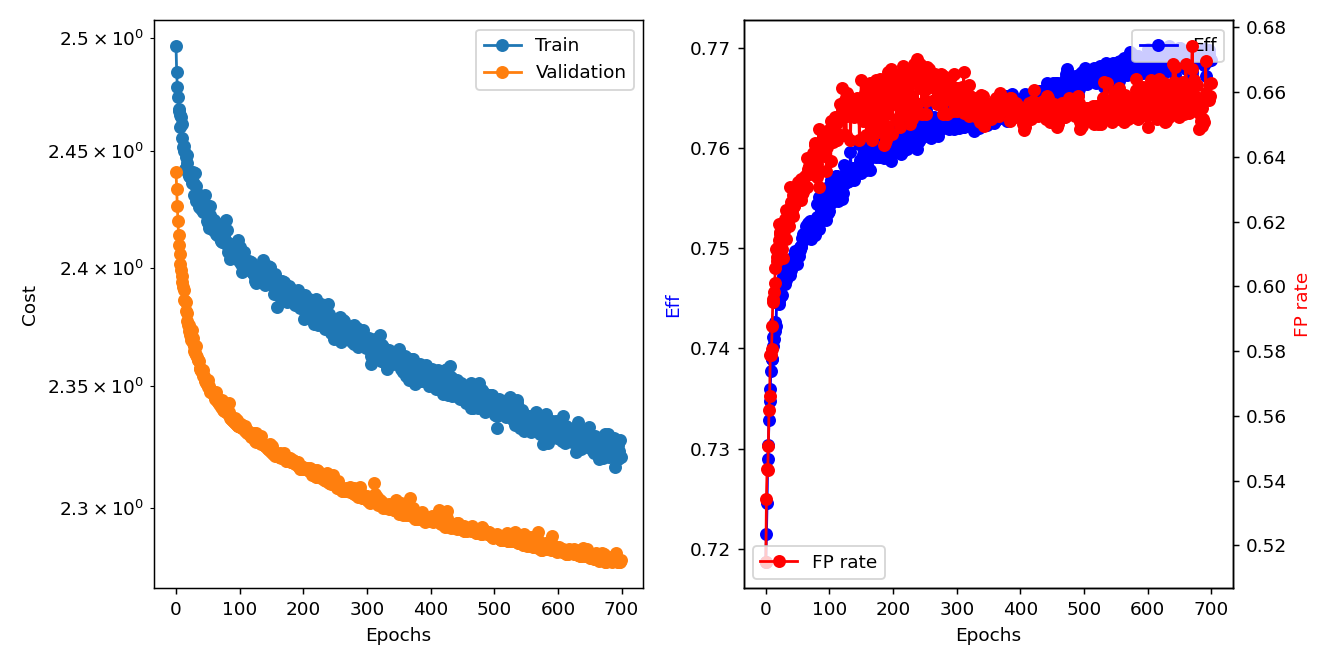

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [20]:
##quit()

